<a href="https://colab.research.google.com/github/Andrea987/advtrain-linreg/blob/main/notebooks/fig1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from re import VERBOSE
from itertools import cycle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn.linear_model import lasso_path
from sklearn import datasets
from sklearn import linear_model
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import tqdm
import cvxpy as cp
print(cp.installed_solvers())
import numpy as np

import traceback


def compute_q(p):
    if p != np.inf and p > 1:
        q = p / (p - 1)
    elif p == 1:
        q = np.inf
    else:
        q = 1
    return q


class AdversarialTraining:
    def __init__(self, X, y, S_dict, p):  # S is the matrix such that ||S^(-1) @ Dx||\leq delta. As a consequence, S appears in the unconstrained problem
        # S: (n, n) matrix, or S = np.concatenate(tS), with tS = [S1,..,S_m], so S is (n * m, n)
        m, n = X.shape
        q = compute_q(p)
        #print("who is X", X)
        #print("who is y", y)
        #print("who is S", S)
        #print("who is q in AdversarialTraining: ", q)
        #Formulate problem
        param = cp.Variable(n)
        #print("shape param ", param.shape)
        #print("dim ", n)
        print("X ", m, n)
        print("Shape ", S.shape)
        #print("S in adv training", S)
        print("nm ", n*m)
        S_dts = S_dict['S_dts']
        S_mis = S_dict['S_mis']
        scale_dts = cp.Parameter(name='scale_dts', nonneg=True)
        scale_mis = cp.Parameter(name='scale_mis', nonneg=True)

        if S_mis.shape == (m, n, n):
          S = S_dts * scale_dts + S_mis * scale_mis
          S = np.concatenate(S)
          print("S is a tensor, concatenated")

        if S.shape == (n, n):
          print("one matrix in input, S.shape = (n, n)")
          partial = S @ param  # should be (m * n,)
          param_norm = cp.pnorm(partial, p=q)
        elif S.shape == (n * m, n):  # should be a stack of matrices
          print("multiple matrices in input, S conc")
          partial = S @ param  # should be (m * n,)
          partial = cp.reshape(partial, (m, n), order='C')
          param_norm = cp.pnorm(partial, p=q, axis=1)
        else:
          print("--------> ERROR: NO MATRIX S FOUND IN ADVERSARIAL TRAINING")
        #elif S.shape == (m , n):  # stack of diagonal matrices
        #  print("multiple matrices in input, S_i diag")
          #S_cvx = cp.Constant(S)
        #  partial = cp.multiply(cp.Parameter(S), param)
        #  param_norm = cp.pnorm(partial, p=q, axis=1)
        adv_radius = cp.Parameter(name='adv_radius', nonneg=True)
        abs_error = cp.abs(X @ param - y)
        adv_loss = 1 / m * cp.sum((abs_error + adv_radius * param_norm) ** 2)
        prob = cp.Problem(cp.Minimize(adv_loss))
        self.prob = prob
        self.adv_radius = adv_radius
        self.scale_dts = scale_dts
        self.scale_mis = scale_mis
        self.param = param
        self.warm_start = False


    def __call__(self, dict_hyper_p, **kwargs):
        try:
            self.adv_radius.value = dict_hyper_p['adv_radius']
            self.scale_dts.value = dict_hyper_p['scale_dts']
            self.scale_mis.value = dict_hyper_p['scale_mis']
            self.prob.solve(warm_start=self.warm_start, solver=cp.CLARABEL, max_iter=10000, **kwargs)
            v = self.param.value
        except Exception as e:
          print("------------------> Error occurred:")
          traceback.print_exc()
          v = np.zeros(self.param.shape)
        #except:
        #    print("----------------------> you are in except")
        #    v = np.zeros(self.param.shape)
        return v

'''
    def __call__(self, adv_radius, **kwargs):
        try:
            self.adv_radius.value = adv_radius
            self.prob.solve(warm_start=self.warm_start, solver=cp.CLARABEL, max_iter=10000, **kwargs)
            v = self.param.value
        except Exception as e:
          print("------------------> Error occurred:")
          traceback.print_exc()
          v = np.zeros(self.param.shape)
        #except:
        #    print("----------------------> you are in except")
        #    v = np.zeros(self.param.shape)
        return v
'''


def get_lasso_path(X, y, eps_lasso=1e-5):
    alphas, coefs, _ = lasso_path(X, y, eps=eps_lasso)
    coefs= np.concatenate([np.zeros([X.shape[1], 1]), coefs], axis=1)
    alphas = np.concatenate([1e2 * np.ones([1]), alphas], axis=0)
    return alphas, coefs, []


def get_path(X, y, estimator, amax, dts_max, mis_max, eps_amax=1e-5, eps_dts_max=1e-1, eps_mis_max=1e-1, n_alphas=25, n_deltas_dts=2, n_deltas_mis=2):
    _, m = X.shape
    amin = eps_amax * amax
    dts_min = eps_dts_max * dts_max
    mis_min = eps_mis_max * mis_max
    alphas = np.logspace(np.log10(amin), np.log10(amax), n_alphas)
    dts_deltas = np.logspace(np.log10(dts_min), np.log10(dts_max), n_deltas_dts)
    mis_deltas = np.logspace(np.log10(mis_min), np.log10(mis_max), n_deltas_mis)
    #hyper_p = {'scale_dts': dts_deltas, 'scale_mis': mis_deltas}
    hyper_p_ret_ = []
    coefs_ = []
    for scale_dts_value in tqdm.tqdm(dts_deltas):
        for scale_mis_value in tqdm.tqdm(mis_deltas):
          #tuple_key = (scale_dts_value, scale_mis_value)
          #coefs_ = []
          for a in tqdm.tqdm(alphas):
              dict_hyper_p_values = {'adv_radius': a, 'scale_dts': scale_dts_value, 'scale_mis': scale_mis_value}
              coefs = estimator(X, y, dict_hyper_p_values)
              #print("alpha  ", a, "coef: ", coefs)
              coefs_.append(coefs if coefs is not None else np.zeros(m))
              hyper_p_ret_.append([a, scale_dts_value, scale_mis_value])
          #res[tuple_key] = np.stack((coefs_)).T
    return np.stack((hyper_p_ret_)).T, np.stack((coefs_)).T

'''
def get_path(X, y, estimator, amax, eps=1e-5, n_alphas=200):
    _, m = X.shape
    amin = eps * amax
    alphas = np.logspace(np.log10(amin), np.log10(amax), n_alphas)
    coefs_ = []
    for a in tqdm.tqdm(alphas):
        coefs = estimator(X, y, a)
        #print("alpha  ", a, "coef: ", coefs)
        coefs_.append(coefs if coefs is not None else np.zeros(m))
    return alphas, np.stack((coefs_)).T
'''


def plot_coefs(alphas, coefs, ax):
    #print("you are printing coefs in function of 1/alphas")
    colors = cycle(["b", "r", "g", "c", "k"])
    #l1norm = np.abs(coefs).sum(axis=0)
    ax.set_xlabel("1/alphas")
    ax.set_ylabel("coef")
    for coef_l, c in zip(coefs, colors):
        ax.semilogx(1/alphas, coef_l, c=c)
        #ax.semilogx(1/alphas, l1norm, c=c)
        #ax.plot(1/alphas, coef_l, c=c)


def plot_coefs_l1norm(coefs, ax):
    #print("you are printing coeff in function of l1 norm")
    colors = cycle(["b", "r", "g", "c", "k"])
    #l1norm = np.abs(coefs).mean(axis=0)
    l1norm = np.abs(coefs).sum(axis=0)
    #print("coef ", coefs)
    #print("l1norm ", l1norm)
    ax.set_xlabel("l1norm")
    ax.set_ylabel("coef")


    for coef_l, c in zip(coefs, colors):
        ax.plot(l1norm, coef_l, c=c)


def train_and_plot(X, y, S_dict, list_ax):
    linfadvtrain = AdversarialTraining(X, y, S_dict, p=np.inf)
    estimator = lambda X, y, a:  linfadvtrain(adv_radius=a)
    alphas_adv, coefs_advtrain_linf  = get_path(X, y, estimator, 1e2, 1e0, 1e0)
    if len(list_ax) > 0:
      plot_coefs_l1norm(coefs_advtrain_linf, list_ax[0])
      plot_coefs(alphas_adv, coefs_advtrain_linf, list_ax[1])
    return alphas_adv, coefs_advtrain_linf

'''
def add_rectangles_old(x, y, box_width, box_height, ax):
  r_c = (np.random.binomial(1, 1, size=x.size) == 1)  # 1 taken, 0 not taken
  #print(r_c)

  for xi, yi in zip(x[r_c], y[r_c]):
      rect = patches.Rectangle(
        (xi-box_width/2, yi-box_height/2),
        box_width, box_height,
        linewidth=1, edgecolor='r', facecolor='none'
      )
      ax.add_patch(rect)
'''

def add_rectangles(x, y, S, ax):
  r_c = (np.random.binomial(1, 1, size=x.size) == 1)  # 1 taken, 0 not taken
  #print(r_c)
  d = S.shape[-1]
  #S = S * 100
  if S.ndim == 2 or S.shape == (1, d, d):
    S = S.squeeze()
    print("------------------------> who is S in add_rectangles\n", S)
    box_width = S[0, 0]
    box_height = S[1, 1]
    for xi, yi in zip(x[r_c], y[r_c]):
        rect = patches.Rectangle(
          (xi-box_width/2, yi-box_height/2),
          box_width, box_height,
          linewidth=1, edgecolor='r', facecolor='none'
        )
        ax.add_patch(rect)
  else:  # S is something like (n, d, d)
    #print("---------------> who is S in add_rectangles (mult imp)\n", S)
    box_width = S[:, 0, 0]
    box_height = S[:, 1, 1]
    #print("bw\n ", box_width)
    #print("bh\n ", box_height)
    #print("------------------------------> boxes printed")
    for xi, yi, bw, bh in zip(x[r_c], y[r_c], box_width[r_c], box_height[r_c]):
        #print("bw, bh ", bw, ",   ", bh)
        rect = patches.Rectangle(
          (xi-bw/2, yi-bh/2),
          bw, bh, linewidth=1, edgecolor='r', facecolor='none'
        )
        ax.add_patch(rect)
    ax.set_aspect('equal')



print("end block")


['CLARABEL', 'CVXOPT', 'GLPK', 'GLPK_MI', 'HIGHS', 'OSQP', 'SCIPY', 'SCS']
end block


In [2]:
# imputation's block

def clear_dataset(X, y, masks):
  # remove observations full NaN
  # X is an (n, d) matrix, y is a (n,) vector,
  # masks is an (n, d) binary matrix associated to X. 1 missing, 0 seen
  M = np.sum(1 - masks, axis=1) > 0
  M_col = np.sum(1 - masks, axis=0) > 0  # True if in the column there is at least one seen component
  if np.sum(M_col) < masks.shape[1]:
    print("Careful, there is one column full of nan")
  return X[M, :][:, M_col], y[M], masks[M, :][:, M_col]


def single_imputation(X_nan, impute_estimator):
    ice = IterativeImputer(estimator=impute_estimator)
    return ice.fit_transform(X_nan)


def multiple_imputation(nbr_mi, X_nan):
    n, d = X_nan.shape
    res = np.zeros((nbr_mi, n, d))
    for i in range(nbr_mi):
       n_i = np.random.randint(0, 1000)
       ice = IterativeImputer(random_state=n_i, max_iter=50, sample_posterior=True)
       res[i, :, :] = ice.fit_transform(X_nan)
       #print("fin res shape", res.shape)
       #if nbr_mi == 1:
        #res = res[0, :, :]
        #print("fin res shape", res.shape)
    return res


def imputation_elliptic(mu, sigma, x, masks):
  # mu, mean elliptical distribution (,d)
  # sigma, cov matrix elliptical distribution (d, d)
  # x: dataset (n, d)
  # masks: mask data, 0 seen, 1 missing
  n, d = x.shape
  print(n, d)
  x_imp = x.copy()
  #print("x_imp clean", x_imp)
  for i in range(n):
    if not (masks[i, :] == 0).all():  # if we have at least one missing component
      #print("nbr : ", i)
      x_c = x[i, :]
      m_bool = (masks[i, :] == 0)  # True seen, False missing
      sigma_aa_inv = np.linalg.inv(sigma[m_bool, :][:, m_bool])
      sigma_ma = sigma[~m_bool, :][:, m_bool]
      mu_cond = mu[~m_bool] + sigma_ma @ sigma_aa_inv @ (x_c[m_bool] - mu[m_bool])
      x_imp[i, ~m_bool] = mu_cond
  return x_imp


def listwise_delection(X, masks):
  # masks: 1 missing, 0 seen
    M = np.sum(masks, axis=1) == 0  # zeros components are the one with full entries
    ret = X[M, :] if X.ndim == 2 else X[M]
    return ret


In [3]:
#np.random.seed(42)

#p_miss_2d = [0.2, 0.4, 0.4]
#beta_2d = np.array([0.5, 2])  # ground truth

from sklearn.datasets import make_moons, make_circles
from sklearn.linear_model import BayesianRidge
from sklearn.model_selection import train_test_split

def generate_masks_2d(nbr_of_sample, p_missing):
    # nbr_of_sample is the number of masks
    # p_missing=[p00, p01, p10], where p00 is the probability of seeing both components,
    # p10 is the probability of seeing the right component, p01 is the probability of seeing the left component
    masks = np.zeros((nbr_of_sample, 2))
    v = np.random.choice(a=3, size=nbr_of_sample, p=p_missing)
    masks[v == 0, :] = np.array([0, 0])  # both seen
    masks[v == 1, :] = np.array([0, 1])  # left seen
    masks[v == 2, :] = np.array([1, 0])  # right seen
    return masks

def best_predictor(X, coeff, y):
  hat_y = (X @ coeff).T  # (n, d) @ (d, m) = (n, m)
  r = hat_y - y  # residual
  score = np.mean(r * r, axis=1)
  print("scores:  ", score)
  i_min = np.argmin(score)
  return coeff[:, i_min], score[i_min]

def best_idx_predictor(X, coeff, y):
  hat_y = (X @ coeff).T  # (n, d) @ (d, m) = (n, m)
  r = hat_y - y  # residual
  #score = np.mean(r * r, axis=1)
  score = np.mean(r * r, axis=1)
  #print("score in best idx", score)
  i_min = np.argmin(score)
  #### find the minimum value with a threshold, so we get bigger uncertainty set that are visible
  min = np.min(score)
  max = np.max(score)
  score[ score < min + 1e-2 ] = max
  ####
  #print("score after ", score)
  i_min = np.argmin(score)
  return i_min, score[i_min]



def generate_X(data, dim):
    if data == 'Gaussian':
      def generator(n):
        return np.random.randn(n, dim)
    elif data == 'Uniform':
      def generator(n):
        return np.random.rand(n, dim)
    elif data == 'moons':
      def generator(n):
        return make_moons(n, noise=0.1)[0]
    elif data == 'circles':
      def generator(n):
        return make_circles(n, noise=0.1, factor=0.4)[0]
    return generator


In [4]:
# experiment 2d with dataset generated externally

def imputations(info, dict_obs_for_imp):  # X_nan, y):
  # info contains the method and possible extra information
  # X_nan is the dataset with nan in place of the missing components
  # y is return as it is, unless the method require to change it, like in
  # listwise deletion
    #print(info)
    X_nan = dict_obs_for_imp['X_nan']
    y = dict_obs_for_imp['y_train']
    mask_from_X_nan = np.isnan(X_nan).astype(int)
    if info['imp_method'] == 'BR_si':  # Baeysian_Ridge_single_imputation
        X = single_imputation(X_nan, BayesianRidge())
    elif info['imp_method'] in  ['mi', 'mi_pure']:
        X = multiple_imputation(info['mi_nbr'], X_nan)
    elif info['imp_method'] == 'l_d':  # listwise_deletion
        #mask_from_X_nan = np.isnan(X_nan).astype(int)
        X = listwise_delection(X_nan, mask_from_X_nan)
        y = listwise_delection(y, mask_from_X_nan)
        if len(X) == 0:  # no elements left, add an artificial element
            X = np.zeros((1, X_nan.shape[-1]))
            y = np.zeros(1)
        mask_from_X_nan = np.zeros_like(X)
    elif info['imp_method'] == 'oracle':
        X = dict_obs_for_imp['X_train_masked'][0]
        mask_from_X_nan = np.zeros_like(X)
    else:
      print("-------------------> ERROR: WRONG KEYWORD (in imputations)")
    return X, y, mask_from_X_nan


def cov_strategy(info, dict_observations):
    X_imputed = dict_observations['X_imputed']
    X_nan = dict_observations['X_nan']
    masks = dict_observations['masks_after_imputation']
    print(np.sum(masks, axis=-1))
    if info['cov_strategy'] == 'sd':
      sd = np.std(X_imputed, axis=0)
      #print("sd in cov strategy ", sd)
      #S = np.diag(sd)  # check if here it is 1 / sd or sd. The intuition is that, small covariance means small boxes where the points can move
      S = np.diag(sd)
    elif info['cov_strategy'] == 'inv_sd':
      sd = np.std(X_imputed, axis=0)
      #S = np.diag(sd)  # check if here it is 1 / sd or sd. The intuition is that, small covariance means small boxes where the points can move
      S = np.diag(1 / sd)
    elif info['cov_strategy'] == 'zero':
      #sd = np.std(X_imputed, axis=0)
      #S = np.diag(sd)  # check if here it is 1 / sd or sd. The intuition is that, small covariance means small boxes where the points can move
      S = np.zeros((X_imputed.shape[-1], X_imputed.shape[-1]))
    elif info['cov_strategy'] == 'eye':
      S = np.eye(X_imputed.shape[-1])
    elif info['cov_strategy'] == 'threshold':
      sd = np.std(X_imputed, axis=0)
      sd[sd < info['threshold']] = info['threshold']
      #S = np.diag(sd) The intuition is that, small covariance means small boxes where the points can move
      S = np.diag(sd)
    elif info['cov_strategy'] == 'std_nan':
        std_columnwise = np.nanstd(X_nan, axis=0)
        S = np.diag(std_columnwise)
    elif info['imp_method'] in ['mi_pure', 'mi']:  # Rubin's Rule
      if info['cov_strategy'] == 'std_mi':
        std_vectors = np.std(X_imputed, axis=-2)  # shape: (m, d)
        #print("std vectors ", std_vectors)
        s_within = np.mean(std_vectors, axis=0)  # within imputation variance  # shape : d
        S = np.diag(s_within)
        print("final S in cov strategy std_mi ", S)
      elif info['cov_strategy'] == 'RR':
        #if info['mi_nbr'] == 1:
        #  X_imputed = np.array([X_imputed])
        # X shape = (m, n, d)
        std_vectors = np.std(X_imputed, axis=-2)  # shape: (m, d)
        #print("std vectors ", std_vectors)
        s_within = np.mean(std_vectors, axis=0)  # within imputation variance  # shape : d
        print("s_within ", s_within)
        print("cov computed")
        #print(s_mean)
        s_between = np.std(std_vectors, axis=0) # between imputation variance  # shape: d. That's already scaled because we are computing the std
        print("s_between ", s_between)
        S = np.diag(s_within + s_between * (1 + 1 / info['mi_nbr']))
        print("final S in cov strategy RR ", S)
        #mu = np.mean(X_imputed, axis=0)
        #sigma = np.cov(X_imputed, rowvar=False)
      elif info['cov_strategy'] == 'RR_scaled (to check)':
        print("Rub Rule right scaled")
        #if info['mi_nbr'] == 1:
        #  X_imputed = np.array([X_imputed])
        # X shape = (m, n, d)
        std_vectors = np.std(X_imputed, axis=-2) # shape: (m, d)
        #print("std vectors ", std_vectors)
        s_within = np.mean(std_vectors, axis=0)  # within imputation variance  # shape : d
        print("s_within ", s_within)
        print("cov computed")
        #print(s_mean)
        s_between = np.std(std_vectors, axis=0) # between imputation variance  # shape: d
        #s_between = np.sqrt(s_between)
        print("s_between ", s_between)
        S = np.diag(s_within + s_between * (1 + 1 / info['mi_nbr']))
        #S = np.sqrt(S)
        print("final S in cov strategy RR ", S)
      #elif info['cov_strategy'] == 'cond_var':
        # we have imputed [X1,..,X_m]
        #s = np.std(X_imputed, axis=0)
        #print("s\n ", s)
        #eye = np.array([np.eye(X_imputed.shape[-1])] * X_imputed.shape[-2])
        #S = eye * s[:, None, :]
        #S = np.concatenate(S, axis=0)
        #print("S in cond variance ", S)
    elif info['cov_strategy'] == 'lounici':
      mu = np.nanmean(X_nan, axis=0)
      print("means ", mu)
      delta = 1 - np.mean(masks) # parameter missingness
      print("delta ", delta)
      X_0 = np.nan_to_num(X_nan - mu)  # check if this is correct
      print("nbr obs", X_0.shape[0])
      S =  X_0.T @ X_0 / X_0.shape[0]
      S = (1/delta - 1/(delta**2)) * np.diag(np.diag(S)) + 1/(delta**2) * S
    else:
      raise ValueError("-------------> ERROR: NO COVARIANCE METHOD HAS BEEN CHOSEN")
      #print("-------------> ERROR: NO COVARIANCE METHOD HAS BEEN CHOSEN")
      #S = np.diag(S)
      #mu = np.mean(X_imputed, axis=0)
      #sigma = np.cov(X_imputed, rowvar=False)
    return S


def cov_strategy_missing(info, dict_observations):
    # undertainty that come from the imputed part. It is zero
    X_imputed = dict_observations['X_imputed']
    if info['imp_method'] in ['mi', 'mi_pure']:
      if info['cov_strategy_between'] == 'cond_var':
        # we have imputed [X1,..,X_m], so shape (m, n, d)
        s = np.std(X_imputed, axis=0)
        s[s<1e-14] = 0  # set to zero values that are basically zero
        #print("var ", s)
        eye = np.array([np.eye(X_imputed.shape[-1])] * X_imputed.shape[-2])
        S_mis = eye * s[:, None, :]
    else:
      print("shape oject in cov strategy missing ", dict_observations['X_test'].shape[-1])
      S_mis = np.zeros_like(dict_observations['X_test'].shape[-1])
    return S_mis


def post_imputation(info_imp, dict_dataset):
  # X_imptued should be a matrix (n, d) or tensor (m, d, n) (in multiple imputations methods)
    X_imputed = dict_dataset['X_imputed']
    y_train = dict_dataset['y_from_X_imputed']
    #print("info imp in post_imp", info_imp)
    print("shape X_imputed in post_imputation ", X_imputed.shape)
    mask_train = dict_dataset['masks_after_imputation']
    if 'post_imp' not in info_imp.keys():
      X_train = X_imputed
    elif info_imp['post_imp'] == 'mean':
      #print("entered in pst_iputation, in mi_mean")
      X_train = np.mean(X_imputed, axis=0)
    elif info_imp['post_imp'] == 'conc':
      X_train = np.concatenate(X_imputed)
    else:
      X_train = X_imputed
    return X_train, y_train, mask_train


def generate_dataset(data, n_tot, dim, beta_gt, perc_test, p_miss, err):
    print(data)
    if data['data'] == 'Gaussian':
      X_complete = np.random.randn(n_tot, dim)
    elif data['data'] == 'Normal':
      #print("you are here")
      X_complete = np.random.multivariate_normal(mean=data['mean'], cov=data['cov'], size=n_tot)
    elif data['data'] == 'Uniform':
      X_complete = np.random.rand(n_tot, dim)
    elif data['data'] == 'moons':
      X_complete = make_moons(n_tot, noise=0.1)[0]
    elif data['data'] == 'circles':
      X_complete = make_circles(n_tot, noise=0.1, factor=0.4)[0]

    if err['type'] == 'Gaussian_on_y':
      #print("---> you have entered in GAUSSIAN ERROR ", "scaling : ", err['scaling'])
      error = np.random.randn(n_tot) * err['scaling']
    elif err['type'] == 'Uniform_on_y':
      error = (np.random.rand(n_tot)-0.5) * err['scaling']
    elif err['type'] == 'Gaussian_on_X':
      error = (np.random.randn(n_tot, dim) @ beta_gt) * err['scaling']  # error is of the form DX@beta_gt + error
    #elif err['type'] == 'Gaussian':
    #  error = np.random.randn(n_tot) * err['scaling']

    print(X_complete.shape)

    y_complete = X_complete @ beta_gt + error  #np.random.randn(n_tot) * err  # (np.random.rand(n_tot) - 0.5) * err
    X_train, X_test, y_train, y_test = train_test_split(X_complete, y_complete, test_size=perc_test)
    n_train = X_train.shape[0]
    masks_train = generate_masks_2d(n_train, p_miss)  # 1 missing, 0 observed
    #M = np.sum(masks, axis=1)  # M[i] > 0 iff i has missing component
    #dict_obs = {'X_train': X_train, 'X_test': X_test, 'y_train': y_train, 'y_test': y_test, 'masks_train': masks_train}
    dict_obs = {'X_train_masked': (X_train, masks_train), 'X_test': X_test, 'y_train': y_train, 'y_test': y_test}#, 'masks_train': masks_train}
    return dict_obs


def experiment_2d_ext_dataset(dict_obs, dict_imp, ax):
    # dict_obs contains info on the observations, i.e. train, test, masks
    # dict_imp contains info on the imputation an covariance methods used,
    # dict_imp = {'imp_method': , 'cov_strategy': , .... }
    # ax contains info for the plots

    X_test = dict_obs['X_test']
    y_test = dict_obs['y_test']
    mask = dict_obs['X_train_masked'][1]

    M = np.sum(mask, axis=1)  # M[i] > 0 iff i has missing component

    X_nan_train = dict_obs['X_train_masked'][0].copy()
    oracle_sd = np.std(X_nan_train, axis=0)
    print("-------> ORACLE SD", oracle_sd)
    X_nan_train[mask == 1] = np.nan
    #print("dict imp -----> ", dict_imp)
    dict_obs = dict_obs | {'X_nan': X_nan_train} #, 'y_from_X_imputed': y_from_X_imputed, 'masks_after_imputation': mask_from_X_imputed}
    if len(dict_obs['imp_ds'][dict_imp['imp_method']]) == 0:
      #results = imputations(dict_imp, X_nan_train, dict_obs['y_train'])
      results = imputations(dict_imp, dict_obs)
      X_imputed, y_from_X_imputed, mask_from_X_imputed = results  # imputations(dict_imp, X_nan_train, dict_obs['y_train'])
      dict_obs['imp_ds'][dict_imp['imp_method']].append(results)
      print("crush test-------------------------------------------------> ", np.sum(X_imputed))
    else:
      X_imputed, y_from_X_imputed, mask_from_X_imputed = dict_obs['imp_ds'][dict_imp['imp_method']][0]
      print("crush test-------------------------------------------------> ", np.sum(X_imputed))
    #print("X_imputed ", X_imputed)
    n_imputed, n_test = X_imputed.shape[-2], X_test.shape[-2]
    #print("X_train\n ", X_train)
    M = np.sum(mask_from_X_imputed, axis=1)  # M[i] > 0 iff i has missing component

    dict_obs = dict_obs | {'X_imputed': X_imputed, 'y_from_X_imputed': y_from_X_imputed, 'masks_after_imputation': mask_from_X_imputed}
    #print(dict_obs)
    S_dataset = cov_strategy(dict_imp, dict_obs)
    print("S dataset \n", S_within)
    #dict_obs = dict_obs | {'cov_within': S_within}
    S_missing = cov_strategy_missing(dict_imp, dict_obs)
    #print("S between ", S_between)
    #dict_obs = dict_obs | {'cov_between': S_between}
    S_dict = {'S_dts': S_dataset, 'S_mis': S_missing, 'multipliers_dts': dict_imp['multip_dataset'], 'multipliers_mis': dict_imp['multip_missing']}
    if True:  # check what to do of this part later
      S = S_dataset * dict_imp['multip_dataset'] + S_missing * dict_imp['multip_missing']
      if S.ndim == 2:
        print("final S \n", S)


    #print("matrices S \n", S)
    #print("---....---....----....--> diag matrix: ", np.diag(S))

    #if dict_imp['imp_method'] == 'mi':  # prepare the training set in case of multiple imputation
    #  X_train = np.concatenate(X_train)  # X_train, if the method is mi, should be (mi_nbr, n, dim)
    #  y_train = np.tile(y_train, reps=dict_imp['mi_nbr'])
    #  mask_train = np.tile(mask_train, reps=(dict_imp['mi_nbr'], 1))
    #  M = np.sum(mask_train, axis=1)
    #print("final matrices (exp 2d ext run)\n ", S)
    X_train, y_train, mask_train = post_imputation(dict_imp, dict_obs)
    n_train = X_train.shape[-2]
    print("y_train length ", y_train.shape[0])
    print("-------> size test: ", n_test, " , size train: ", n_train, "nbr_seen (train): ", np.sum(M == 0), " nbr_miss : ", np.sum(M > 0))

#    plt.tight_layout()
    S_between = S.copy()
    if dict_imp['imp_method'] == 'mi_pure':
      best_coeff = np.zeros(X_train.shape[-1])
      best_alpha = 0
      for i in range(dict_imp['mi_nbr']):
        print("i .-------------> ", i)
        dict_obs_i = {'X_imputed': X_train[i, :, :], 'X_nan': X_nan_train, 'masks': mask_train}
        dict_imp_new = {'imp_method': dict_imp['imp_method'], 'cov_strategy': dict_imp['cov_strategy_within']}
        S_within = cov_strategy(dict_imp_new, dict_obs_i)  # within the dataset
        #print("S_within ", S_within)
        S = S_within[None, :, :] + S_between
        S = np.concatenate(S, axis=0)
        #print(S)
        alphas_used, coeff_results = train_and_plot(X_train[i, :, :], y_train, S, [ax[1], ax[2]])
        idx_best, min_score = best_idx_predictor(X_test, coeff_results, y_test)
        best_coeff_partial, best_alpha_partial = coeff_results[:, idx_best], alphas_used[idx_best]
        print("best coeff partial ", best_coeff_partial)
        best_coeff += best_coeff_partial
        best_alpha += best_alpha_partial
        ax[0].scatter(X_train[i, M == 0, 0], X_train[i, M == 0, 1])
        ax[0].scatter(X_train[i, M == 1, 0], X_train[i, M == 1, 1])
        ax[0].set_title(dict_imp['imp_method'] + ', ' + dict_imp['cov_strategy'] + ', n_s: ' + str(np.sum(M == 0)) + " n_m: " + str(np.sum(M > 0)))  # n_s = nbr seen, n_m = nbr missing
        add_rectangles(X_train[i, :, 0], X_train[i, :, 1], S[0, 0] * best_alpha_partial, S[1, 1] * best_alpha_partial, ax[0])
        best_coeff /= dict_imp['mi_nbr']
      best_alpha /= dict_imp['mi_nbr']
    else:
      #alphas_used, coeff_results = train_and_plot(X_train, y_train, S_dict, [ax[1], ax[2]])
      hyper_p_used, coeff_results = train_and_plot(X_train, y_train, S_dict, [])
      idx_best, min_score = best_idx_predictor(X_test, coeff_results, y_test)
      #best_coeff, best_alpha = coeff_results[:, idx_best], alphas_used[idx_best]
      best_coeff, best_hyper_p = coeff_results[:, idx_best], hyper_p_used[:, idx_best]
      #print(X_br_train[M == 0, 0])
      ax[0].scatter(X_train[M == 0, 0], X_train[M == 0, 1])
      ax[0].scatter(X_train[M == 1, 0], X_train[M == 1, 1])
      #ax[0].set_title(dict_imp['imp_method'] + ', ' + dict_imp['cov_strategy'] + ', n_s: ' + str(np.sum(M == 0)) + " n_m: " + str(np.sum(M > 0)))  # n_s = nbr seen, n_m = nbr missing
      # 'multip_betw': 1, 'multip_with':1
      ax[0].set_title(dict_imp['imp_method'] + ', ' + dict_imp['cov_strategy'] + ', dts:'+str(dict_imp['multip_dataset']) + ', mis:' + str(dict_imp['multip_missing']) )  # n_s = nbr seen, n_m = nbr missing
      S_plot = (S_dict['S_dts'] * best_hyper_p[1] + S_dict['S_mis'] * best_hyper_p[2]) * best_hyper_p[0]
      #print("S_plot ", S_plot)
      add_rectangles(X_train[:, 0], X_train[:, 1], S_plot, ax[0])
      ax[0].set_aspect('equal')  # equal proportion of the axis
    #print("X_train ", X_train)
    #print("y_train ", y_train)
    #print("mask_train ", mask_train)
    #print("M ", M)


    print("X_test shape, ", X_test.shape, ",   y_test shape ", y_test.shape)
    #print("X_test shape, ", X_test.shape)
    print("---------------------------------> best idx ", idx_best, " best 1/best_alpha ", 1 / best_alpha, ", min score ", min_score)
    print("---------------------------------> best coeff ", best_coeff)
    #print("best 1/alpha ", 1 / best_alpha)
#    print("min score ", min_score)

    #
    #add_rectangles(X_train[:, 0], X_train[:, 1], S[0, 0] * best_alpha, S[1, 1] * best_alpha, ax[0])

    return best_coeff, min_score, -np.log10(best_alpha)



In [5]:

def run_experiments(dictio, methods_strategy):  # ---------------------> new
  # dictio: dictionary of lists that contains the parameters of generate_dataset.
  # Each list should have the same length
  # methods_strategy = list of dictionary, each one of the form
  # {'imp_method': .., 'cov_strategy':.., extra info}

    l = len(dictio['data'])
    m = len(methods_strategy)
    nbr_iter = len(methods_strategy)
    coeff_fin = np.zeros((nbr_iter, 2, l))
    scores_fin = np.zeros((nbr_iter, l))

    #fig, ax = plt.subplots(3 * nbr_iter, l, figsize=(3 * l , 9 *l), num='advtrain_linf_')
    #fig, ax = plt.subplots(3 * nbr_iter, l, figsize=(6 * l , 9 *l), num='advtrain_linf_')
    #fig, ax = plt.subplots(3 * nbr_iter, l, figsize=(6 * l / 2, 9 *l / 2), num='advtrain_linf_')
    fig, ax = plt.subplots(3 * nbr_iter, l, figsize=(3 * l, 8 * m), num='advtrain_linf_', squeeze=False)

    res = {}
    for info_imp_cov_dict in methods_strategy:
      key_list = []
      for value in info_imp_cov_dict.values():
        print(value)
        key_list.append(value)
      key_tuple = tuple(key_list)
      res[key_tuple] = {'best_coeff':[], 'l2_dist_best_coeff_gt':[], 'best_score':[], 'best_alpha':[]}
      #res[(info_imp_cov_dict['imp_method'], info_imp_cov_dict['cov_strategy'])] = {'best_coeff':[], 'l2_dist_best_coeff_gt':[], 'best_score':[], 'best_alpha':[]}

    if dictio['generation'] == 'fixed':  # use this if you want to fix the generated data, and not change at every iteartion
      dictio_obser_fixed = dict_obser = generate_dataset(data=dictio['data'][0],
                                    n_tot=dictio['n_tot'][0],
                                    dim=dictio['dim'][0],
                                    beta_gt=dictio['beta_gt'][0],
                                    perc_test=dictio['perc_test'][0],
                                    p_miss=dictio['p_miss'][0],
                                    err=dictio['err'][0])
      mask_no_both_seen = generate_masks_2d(dictio['n_train'][0], [0, 0.5, 0.5]) # generate a mask where there are no entries both seen. The idea then will be to consider percentage of this mask seen

    for i in range(l):
      print("---------------------------------------------------------------------------------------------------------------------------> iteration ", i)
      #  dict_obs = {'X_train_masked': (X_train, masks_train), 'X_test': ....., 'y_train': ....., 'y_test': ....}
      dict_obser_partial = generate_dataset(data=dictio['data'][i],
                                    n_tot=dictio['n_tot'][i],
                                    dim=dictio['dim'][i],
                                    beta_gt=dictio['beta_gt'][i],
                                    perc_test=dictio['perc_test'][i],
                                    p_miss=dictio['p_miss'][i],
                                    err=dictio['err'][i])
      if dictio['generation'] == 'fixed':
        dict_obser = dictio_obser_fixed
        #mask_partial = dict_obser_partial['X_train_masked'][1]
        p_i = dictio['p_miss'][i][0]  # probability of seen both component at round i
        n_train = mask_no_both_seen.shape[0]
        mask_partial = mask_no_both_seen.copy()
        mask_partial[0:int(n_train * p_i), :] = 0
        #mask_partial = mask_no_both_seen[0:int(n_train * p_i), :]
        tuple_partial = (dictio_obser_fixed['X_train_masked'][0], mask_partial)
        dict_obser['X_train_masked'] = tuple_partial
      else:
        dict_obser = dict_obser_partial

      #print("dict obser ", dict_obser)
      dict_obser = dict_obser | {'imp_ds':{'BR_si':[], 'l_d':[], 'oracle':[], 'mi':[]}}  # add an entry for imputed dataset
      for idx, info_imp_cov_dict in enumerate(methods_strategy):
        print("----------------------------------------------> new method tested: ", info_imp_cov_dict)
        coeff_round, score_round, alpha_round = experiment_2d_ext_dataset(dict_obser, info_imp_cov_dict, ax[(idx * 3):((idx+1)*3), i])
        r = coeff_round - dictio['beta_gt'][i]
        l2_dist = np.linalg.norm(r)
        key_list = []
        for value in info_imp_cov_dict.values():
          print(value)
          key_list.append(value)
        key_tuple = tuple(key_list)
        res[key_tuple]['l2_dist_best_coeff_gt'].append(l2_dist)
        res[key_tuple]['best_coeff'].append(coeff_round)
        res[key_tuple]['best_score'].append(score_round)
        res[key_tuple]['best_alpha'].append(alpha_round)
        #res[(info_imp_cov_dict['imp_method'], info_imp_cov_dict['cov_strategy'])]['l2_dist_best_coeff_gt'].append(l2_dist)
        #res[(info_imp_cov_dict['imp_method'], info_imp_cov_dict['cov_strategy'])]['best_coeff'].append(coeff_round)
        #res[(info_imp_cov_dict['imp_method'], info_imp_cov_dict['cov_strategy'])]['best_score'].append(score_round)
        #res[(info_imp_cov_dict['imp_method'], info_imp_cov_dict['cov_strategy'])]['best_alpha'].append(alpha_round)
    plt.tight_layout()
    return res


def plot_res(x_axis_info, res, extra_info):
  x_axis = x_axis_info['vector']
  print("x_axis for print in plot_res----> ", x_axis)
  l = len(x_axis)
  fig_res, ax_res = plt.subplots(1, 3, figsize=(25, 5), num='advtrain_linf_res')
  positions = range(l)

  for key, values in res.items():
    print("key ", key, ": ", values)
    #print("values ", values)
  #print("res\n ", res)

  ch = ['o', 'x', '+', '*', '<', '>', 'p', 'D', 'd', 'v']
  lb = ['l2_dist_best_coeff_gt', 'best_score', 'best_alpha']
  for i in range(3):
    for idx, (key, dictio) in enumerate(res.items()):
      #print(dictio)
      ax_res[i].plot(positions, dictio[lb[i]], marker=ch[idx], label=str(key))  # the marker is linked to the key (= method), different key correspond to different marker
      #ax_res[1].plot(positions, dictio[lb[idx]], marker=ch[idx], label=str(key))
      #ax_res[2].plot(positions, -np.log(dictio['best_alpha']), marker=ch[idx], label=str(key))
      #ax_res[0].xticks(positions, n_tot)  # Set custom labels for the x-axis
    ax_res[i].set_xticks(positions)         # Set the tick positions
    ax_res[i].set_xticklabels(x_axis)        # Set the labels at those positions
    ax_res[i].set_xlabel(x_axis_info['name'])
    #ax_res[i].legend(loc='upper center', bbox_to_anchor=(1, 1))
    ax_res[i].legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)
  ax_res[0].set_ylabel("||hat_Beta - Beta^*||_2")
  ax_res[1].set_ylabel("||hat_y - y||_2^2 / n_test")
  dict_err = extra_info['err'][0]
  #size_train = extra_info['n_tot'][0]
  ax_res[0].set_title("")
  n_test = extra_info['n_test'][0]
  #ax_res[1].set_title("err: " + dict_err['type'] + ", scale: " + str(dict_err['scaling'])  + ", n_test: " + str(n_test))
  ax_res[1].set_title("n_test: " + str(n_test))
  ax_res[2].set_ylabel("-log10(alpha)")
  plt.tight_layout()


def make_dictionary_data(nbr_experiments, n_train, n_test, data, beta_gt, p_miss, err_vector):
  # make a dictionary where each element is a list of nbr_experiments element made by the other element of the function
  if isinstance(n_train, int):  # in case n_train is just a number
    n_train = [n_train] * nbr_experiments
  else:  # should be a list of integer
    print("change nbr_experiments to match the size of n_train")
    nbr_experiments = len(n_train)
  if isinstance(n_test, int):  # in case n_test is just a number
    n_test = [n_test] * nbr_experiments
  n_tot = [x + y for x, y in zip(n_train, n_test)]
  perc_test = [x / (x+y) for x, y in zip(n_test, n_train)]
  dim = beta_gt.size

  list_errors = []
  for i in range(nbr_experiments):
    err_dic_app = {'type': err_vector[0], 'scaling': err_vector[1][i]}
    list_errors.append(err_dic_app)

  dictio = {'data':[data] * nbr_experiments,
        'n_tot': n_tot,
        'n_train': n_train,
        'n_test': n_test,
        'dim': [dim] * nbr_experiments,
        'beta_gt': [beta_gt] * nbr_experiments,
        'perc_test': perc_test,
        #'p_miss': [p_miss] * nbr_experiments,
        'err': list_errors
        }
  dictio['p_miss'] = p_miss

  return dictio

def make_probabilities(list_prob):
  l = []
  for x in list_prob:
    l.append([x, 0.5 - x/2, 0.5 - x/2])
  return l

def make_info_axis(vector, name):
  if name == 'train':
    dictio = {'name': 'size train set', 'vector': vector}
  elif name == 'p_seen':
    dictio = {'name': 'probability seen full entries', 'vector': vector}
  elif name == 'error':
    dictio = {'name': 'error', 'vector': vector}
  else:
    print("wrong info_axis")
  return dictio

def make_dictionary_method(list_meth):
  # make a dictionary where each element is a list of nbr_experiments element made by the other element of the function
  list_dictio=[]
  list_key = ['imp_method', 'cov_strategy', 'mi_nbr']
  for meth in list_meth:
    dictio_imp = {}
    for i in range(len(meth)):
      dictio_imp[list_key[i]] = meth[i] #= {list_key[i]: meth[i]}
      #print(dictio_imp)
    list_dictio.append(dictio_imp)
  return list_dictio



change nbr_experiments to match the size of n_train
data :  {'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[ 1. , -0.1],
       [-0.1,  1. ]])}
n_tot :  20010
n_train :  10
n_test :  20000
dim :  2
beta_gt :  [-0.5  2. ]
perc_test :  0.9995002498750625
err :  {'type': 'Gaussian_on_y', 'scaling': 3.5}
p_miss :  [0.5, 0.25, 0.25]
generation :  f
[{'imp_method': 'BR_si', 'cov_strategy': 'eye', 'multip_betw': 1, 'multip_with': 1}, {'imp_method': 'l_d', 'cov_strategy': 'eye', 'multip_betw': 1, 'multip_with': 1}, {'imp_method': 'oracle', 'cov_strategy': 'eye', 'multip_betw': 1, 'multip_with': 1}, {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'RR', 'mi_nbr': 12, 'multip_betw': 0, 'multip_with': 0}, {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'RR', 'mi_nbr': 12, 'multip_betw': 0, 'multip_with': 1}, {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 

100%|██████████| 200/200 [00:00<00:00, 384.47it/s]


------------------------> who is S in add_rectangles
 [[0.77525975 0.        ]
 [0.         0.77525975]]
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  115  best 1/best_alpha  1.289890261253308 , min score  16.16886351425301
---------------------------------> best coeff  [-8.81792312e-01  5.51571579e-11]
BR_si
eye
1
1
----------------------------------------------> new method tested:  {'imp_method': 'l_d', 'cov_strategy': 'eye', 'multip_betw': 1, 'multip_with': 1}
-------> ORACLE SD [1.06740426 0.6952932 ]
crush test------------------------------------------------->  -3.7348711303776314
[0. 0. 0. 0. 0.]
S within 
 [[1. 0.]
 [0. 1.]]
final S 
 [[1. 0.]
 [0. 1.]]
shape X_imputed in post_imputation  (5, 2)
y_train length  5
-------> size test:  20000  , size train:  5 nbr_seen (train):  5  nbr_miss :  0
X  5 2
Shape  (2, 2)
nm  10
one matrix in input, S.shape = (n, n)


100%|██████████| 200/200 [00:00<00:00, 449.93it/s]


------------------------> who is S in add_rectangles
 [[1.03532184 0.        ]
 [0.         1.03532184]]
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  120  best 1/best_alpha  0.9658832241158699 , min score  16.191802508390936
---------------------------------> best coeff  [-5.03163666e-01  9.51516563e-11]
l_d
eye
1
1
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'eye', 'multip_betw': 1, 'multip_with': 1}
-------> ORACLE SD [1.06740426 0.6952932 ]
crush test------------------------------------------------->  -5.371438339966941
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
S within 
 [[1. 0.]
 [0. 1.]]
final S 
 [[1. 0.]
 [0. 1.]]
shape X_imputed in post_imputation  (10, 2)
y_train length  10
-------> size test:  20000  , size train:  10 nbr_seen (train):  10  nbr_miss :  0
X  10 2
Shape  (2, 2)
nm  20
one matrix in input, S.shape = (n, n)


100%|██████████| 200/200 [00:00<00:00, 418.24it/s]


------------------------> who is S in add_rectangles
 [[0.00850449 0.        ]
 [0.         0.00850449]]
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  37  best 1/best_alpha  117.5849554052157 , min score  14.42542007048511
---------------------------------> best coeff  [-1.99723807  1.63268856]
oracle
eye
1
1
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'RR', 'mi_nbr': 12, 'multip_betw': 0, 'multip_with': 0}
-------> ORACLE SD [1.06740426 0.6952932 ]
crush test------------------------------------------------->  -73.65973339505501
[0 0 0 0 0 1 1 1 1 1]
s_within  [1.21623734 0.75689438]
cov computed
s_between  [0.087211   0.03891367]
final S in cov strategy RR  [[1.31071592 0.        ]
 [0.         0.79905085]]
S within 
 [[1.31071592 0.        ]
 [0.         0.79905085]]
shape X_imputed in post_imputation  (12, 10, 2)
y_t

100%|██████████| 200/200 [00:00<00:00, 395.00it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best 1/best_alpha  1000.0 , min score  24.416242321813144
---------------------------------> best coeff  [-3.31889789 -0.40461882]
mi
mean
cond_var
RR
12
0
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'RR', 'mi_nbr': 12, 'multip_betw': 0, 'multip_with': 1}
-------> ORACLE SD [1.06740426 0.6952932 ]
crush test------------------------------------------------->  -73.65973339505501
[0 0 0 0 0 1 1 1 1 1]
s_within  [1.21623734 0.75689438]
cov computed
s_between  [0.087211   0.03891367]
final S in cov strategy RR  [[1.31071592 0.        ]
 [0.         0.79905085]]
S within 
 [[1.31071592 0.        ]
 [0.         0.79905085]]
shape X_imputed in post_imputation  (12, 10, 2)
y_train length  10
-------> size test:  20000  , size train:  10 nbr_seen (train):  5  nbr_miss :  5
X  10 

100%|██████████| 200/200 [00:00<00:00, 385.00it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  113  best 1/best_alpha  1.448118227674533 , min score  16.167142534720345
---------------------------------> best coeff  [-5.69311828e-01  6.80845668e-08]
mi
mean
cond_var
RR
12
0
1
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'RR', 'mi_nbr': 12, 'multip_betw': 3, 'multip_with': 0}
-------> ORACLE SD [1.06740426 0.6952932 ]
crush test------------------------------------------------->  -73.65973339505501
[0 0 0 0 0 1 1 1 1 1]
s_within  [1.21623734 0.75689438]
cov computed
s_between  [0.087211   0.03891367]
final S in cov strategy RR  [[1.31071592 0.        ]
 [0.         0.79905085]]
S within 
 [[1.31071592 0.        ]
 [0.         0.79905085]]
shape X_imputed in post_imputation  (12, 10, 2)
y_train length  10
-------> size test:  20000  , size train:  10 nbr_seen (train):  5 

100%|██████████| 200/200 [00:00<00:00, 367.22it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  122  best 1/best_alpha  0.8603464416684501 , min score  12.389053217635286
---------------------------------> best coeff  [-0.40809159  1.69734664]
mi
mean
cond_var
RR
12
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'RR', 'mi_nbr': 12, 'multip_betw': 3, 'multip_with': 1}
-------> ORACLE SD [1.06740426 0.6952932 ]
crush test------------------------------------------------->  -73.65973339505501
[0 0 0 0 0 1 1 1 1 1]
s_within  [1.21623734 0.75689438]
cov computed
s_between  [0.087211   0.03891367]
final S in cov strategy RR  [[1.31071592 0.        ]
 [0.         0.79905085]]
S within 
 [[1.31071592 0.        ]
 [0.         0.79905085]]
shape X_imputed in post_imputation  (12, 10, 2)
y_train length  10
-------> size test:  20000  , size train:  10 nbr_seen (train):  5  nbr_mi

100%|██████████| 200/200 [00:00<00:00, 385.64it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  105  best 1/best_alpha  2.300430119772917 , min score  14.341291741162394
---------------------------------> best coeff  [-0.50344272  0.54757015]
mi
mean
cond_var
RR
12
3
1
---------------------------------------------------------------------------------------------------------------------------> iteration  1
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[ 1. , -0.1],
       [-0.1,  1. ]])}
(20010, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'eye', 'multip_betw': 1, 'multip_with': 1}
-------> ORACLE SD [1.06740426 0.6952932 ]
crush test------------------------------------------------->  -6.791260172042664
[0 0 0 0 1 1 1 1 1 1]
S within 
 [[1. 0.]
 [0. 1.]]
final S 
 [[1. 0.]
 [0. 1.]]
shape X_imputed in post_imputation  (10, 2)
y_train length  10
-------> size test:  20000  , size train:  10 nbr_seen (train):  4 

100%|██████████| 200/200 [00:00<00:00, 450.11it/s]


------------------------> who is S in add_rectangles
 [[0.77525975 0.        ]
 [0.         0.77525975]]
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  115  best 1/best_alpha  1.289890261253308 , min score  16.16974895905213
---------------------------------> best coeff  [-8.84555201e-01  6.03054606e-11]
BR_si
eye
1
1
----------------------------------------------> new method tested:  {'imp_method': 'l_d', 'cov_strategy': 'eye', 'multip_betw': 1, 'multip_with': 1}
-------> ORACLE SD [1.06740426 0.6952932 ]
crush test------------------------------------------------->  -3.413622987872188
[0. 0. 0. 0.]
S within 
 [[1. 0.]
 [0. 1.]]
final S 
 [[1. 0.]
 [0. 1.]]
shape X_imputed in post_imputation  (4, 2)
y_train length  4
-------> size test:  20000  , size train:  4 nbr_seen (train):  4  nbr_miss :  0
X  4 2
Shape  (2, 2)
nm  8
one matrix in input, S.shape = (n, n)


100%|██████████| 200/200 [00:00<00:00, 447.24it/s]


------------------------> who is S in add_rectangles
 [[1.2315506 0.       ]
 [0.        1.2315506]]
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  123  best 1/best_alpha  0.811984499318401 , min score  16.237673686979086
---------------------------------> best coeff  [-4.15958710e-01  8.13380787e-10]
l_d
eye
1
1
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'eye', 'multip_betw': 1, 'multip_with': 1}
-------> ORACLE SD [1.06740426 0.6952932 ]
crush test------------------------------------------------->  -5.371438339966941
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
S within 
 [[1. 0.]
 [0. 1.]]
final S 
 [[1. 0.]
 [0. 1.]]
shape X_imputed in post_imputation  (10, 2)
y_train length  10
-------> size test:  20000  , size train:  10 nbr_seen (train):  10  nbr_miss :  0
X  10 2
Shape  (2, 2)
nm  20
one matrix in input, S.shape = (n, n)


100%|██████████| 200/200 [00:00<00:00, 329.63it/s]


------------------------> who is S in add_rectangles
 [[0.00850449 0.        ]
 [0.         0.00850449]]
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  37  best 1/best_alpha  117.5849554052157 , min score  14.42542007048511
---------------------------------> best coeff  [-1.99723807  1.63268856]
oracle
eye
1
1
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'RR', 'mi_nbr': 12, 'multip_betw': 0, 'multip_with': 0}
-------> ORACLE SD [1.06740426 0.6952932 ]
crush test------------------------------------------------->  -89.94724524309137
[0 0 0 0 1 1 1 1 1 1]
s_within  [1.17062793 0.75969394]
cov computed
s_between  [0.10144493 0.04460971]
final S in cov strategy RR  [[1.28052661 0.        ]
 [0.         0.80802113]]
S within 
 [[1.28052661 0.        ]
 [0.         0.80802113]]
shape X_imputed in post_imputation  (12, 10, 2)
y_t

100%|██████████| 200/200 [00:00<00:00, 417.05it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best 1/best_alpha  1000.0 , min score  20.11791425897287
---------------------------------> best coeff  [-2.94430185  0.3008272 ]
mi
mean
cond_var
RR
12
0
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'RR', 'mi_nbr': 12, 'multip_betw': 0, 'multip_with': 1}
-------> ORACLE SD [1.06740426 0.6952932 ]
crush test------------------------------------------------->  -89.94724524309137
[0 0 0 0 1 1 1 1 1 1]
s_within  [1.17062793 0.75969394]
cov computed
s_between  [0.10144493 0.04460971]
final S in cov strategy RR  [[1.28052661 0.        ]
 [0.         0.80802113]]
S within 
 [[1.28052661 0.        ]
 [0.         0.80802113]]
shape X_imputed in post_imputation  (12, 10, 2)
y_train length  10
-------> size test:  20000  , size train:  10 nbr_seen (train):  4  nbr_miss :  6
X  10 2

100%|██████████| 200/200 [00:00<00:00, 353.74it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  110  best 1/best_alpha  1.7225859653987856 , min score  16.166876499433084
---------------------------------> best coeff  [-8.75415268e-01  4.02679754e-07]
mi
mean
cond_var
RR
12
0
1
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'RR', 'mi_nbr': 12, 'multip_betw': 3, 'multip_with': 0}
-------> ORACLE SD [1.06740426 0.6952932 ]
crush test------------------------------------------------->  -89.94724524309137
[0 0 0 0 1 1 1 1 1 1]
s_within  [1.17062793 0.75969394]
cov computed
s_between  [0.10144493 0.04460971]
final S in cov strategy RR  [[1.28052661 0.        ]
 [0.         0.80802113]]
S within 
 [[1.28052661 0.        ]
 [0.         0.80802113]]
shape X_imputed in post_imputation  (12, 10, 2)
y_train length  10
-------> size test:  20000  , size train:  10 nbr_seen (train):  4

100%|██████████| 200/200 [00:00<00:00, 364.93it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  114  best 1/best_alpha  1.366716356462006 , min score  12.538354618022673
---------------------------------> best coeff  [-0.67126085  1.48324616]
mi
mean
cond_var
RR
12
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'RR', 'mi_nbr': 12, 'multip_betw': 3, 'multip_with': 1}
-------> ORACLE SD [1.06740426 0.6952932 ]
crush test------------------------------------------------->  -89.94724524309137
[0 0 0 0 1 1 1 1 1 1]
s_within  [1.17062793 0.75969394]
cov computed
s_between  [0.10144493 0.04460971]
final S in cov strategy RR  [[1.28052661 0.        ]
 [0.         0.80802113]]
S within 
 [[1.28052661 0.        ]
 [0.         0.80802113]]
shape X_imputed in post_imputation  (12, 10, 2)
y_train length  10
-------> size test:  20000  , size train:  10 nbr_seen (train):  4  nbr_mis

100%|██████████| 200/200 [00:00<00:00, 355.04it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  101  best 1/best_alpha  2.8994228538828755 , min score  13.960497928748774
---------------------------------> best coeff  [-0.6474497   0.67874419]
mi
mean
cond_var
RR
12
3
1
---------------------------------------------------------------------------------------------------------------------------> iteration  2
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[ 1. , -0.1],
       [-0.1,  1. ]])}
(20010, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'eye', 'multip_betw': 1, 'multip_with': 1}
-------> ORACLE SD [1.06740426 0.6952932 ]
crush test------------------------------------------------->  -6.324440095777227
[0 0 0 1 1 1 1 1 1 1]
S within 
 [[1. 0.]
 [0. 1.]]
final S 
 [[1. 0.]
 [0. 1.]]
shape X_imputed in post_imputation  (10, 2)
y_train length  10
-------> size test:  20000  , size train:  10 nbr_seen (train):  3

100%|██████████| 200/200 [00:00<00:00, 429.53it/s]


------------------------> who is S in add_rectangles
 [[0.87035914 0.        ]
 [0.         0.87035914]]
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  117  best 1/best_alpha  1.1489510001873087 , min score  16.175167106347025
---------------------------------> best coeff  [-5.45064140e-01  1.26421405e-10]
BR_si
eye
1
1
----------------------------------------------> new method tested:  {'imp_method': 'l_d', 'cov_strategy': 'eye', 'multip_betw': 1, 'multip_with': 1}
-------> ORACLE SD [1.06740426 0.6952932 ]
crush test------------------------------------------------->  -2.2601515866257063
[0. 0. 0.]
S within 
 [[1. 0.]
 [0. 1.]]
final S 
 [[1. 0.]
 [0. 1.]]
shape X_imputed in post_imputation  (3, 2)
y_train length  3
-------> size test:  20000  , size train:  3 nbr_seen (train):  3  nbr_miss :  0
X  3 2
Shape  (2, 2)
nm  6
one matrix in input, S.shape = (n, n)


100%|██████████| 200/200 [00:00<00:00, 471.77it/s]


------------------------> who is S in add_rectangles
 [[1.16232247 0.        ]
 [0.         1.16232247]]
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  122  best 1/best_alpha  0.8603464416684501 , min score  16.21032628148324
---------------------------------> best coeff  [-9.81211371e-01  8.17733827e-11]
l_d
eye
1
1
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'eye', 'multip_betw': 1, 'multip_with': 1}
-------> ORACLE SD [1.06740426 0.6952932 ]
crush test------------------------------------------------->  -5.371438339966941
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
S within 
 [[1. 0.]
 [0. 1.]]
final S 
 [[1. 0.]
 [0. 1.]]
shape X_imputed in post_imputation  (10, 2)
y_train length  10
-------> size test:  20000  , size train:  10 nbr_seen (train):  10  nbr_miss :  0
X  10 2
Shape  (2, 2)
nm  20
one matrix in input, S.shape = (n, n)


100%|██████████| 200/200 [00:00<00:00, 413.88it/s]


------------------------> who is S in add_rectangles
 [[0.00850449 0.        ]
 [0.         0.00850449]]
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  37  best 1/best_alpha  117.5849554052157 , min score  14.42542007048511
---------------------------------> best coeff  [-1.99723807  1.63268856]
oracle
eye
1
1
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'RR', 'mi_nbr': 12, 'multip_betw': 0, 'multip_with': 0}
-------> ORACLE SD [1.06740426 0.6952932 ]
crush test------------------------------------------------->  -79.29670658419099
[0 0 0 1 1 1 1 1 1 1]
s_within  [1.16614343 0.74356619]
cov computed
s_between  [0.09091954 0.05624846]
final S in cov strategy RR  [[1.26463959 0.        ]
 [0.         0.80450202]]
S within 
 [[1.26463959 0.        ]
 [0.         0.80450202]]
shape X_imputed in post_imputation  (12, 10, 2)
y_t

100%|██████████| 200/200 [00:00<00:00, 392.03it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best 1/best_alpha  1000.0 , min score  22.412137391108338
---------------------------------> best coeff  [-3.25330905  0.03828353]
mi
mean
cond_var
RR
12
0
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'RR', 'mi_nbr': 12, 'multip_betw': 0, 'multip_with': 1}
-------> ORACLE SD [1.06740426 0.6952932 ]
crush test------------------------------------------------->  -79.29670658419099
[0 0 0 1 1 1 1 1 1 1]
s_within  [1.16614343 0.74356619]
cov computed
s_between  [0.09091954 0.05624846]
final S in cov strategy RR  [[1.26463959 0.        ]
 [0.         0.80450202]]
S within 
 [[1.26463959 0.        ]
 [0.         0.80450202]]
shape X_imputed in post_imputation  (12, 10, 2)
y_train length  10
-------> size test:  20000  , size train:  10 nbr_seen (train):  3  nbr_miss :  7
X  10 

100%|██████████| 200/200 [00:00<00:00, 236.88it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  113  best 1/best_alpha  1.448118227674533 , min score  16.17852960286373
---------------------------------> best coeff  [-5.35835122e-01  9.21452353e-08]
mi
mean
cond_var
RR
12
0
1
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'RR', 'mi_nbr': 12, 'multip_betw': 3, 'multip_with': 0}
-------> ORACLE SD [1.06740426 0.6952932 ]
crush test------------------------------------------------->  -79.29670658419099
[0 0 0 1 1 1 1 1 1 1]
s_within  [1.16614343 0.74356619]
cov computed
s_between  [0.09091954 0.05624846]
final S in cov strategy RR  [[1.26463959 0.        ]
 [0.         0.80450202]]
S within 
 [[1.26463959 0.        ]
 [0.         0.80450202]]
shape X_imputed in post_imputation  (12, 10, 2)
y_train length  10
-------> size test:  20000  , size train:  10 nbr_seen (train):  3  

100%|██████████| 200/200 [00:00<00:00, 256.22it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  108  best 1/best_alpha  1.9338917504552302 , min score  12.368171953640621
---------------------------------> best coeff  [-0.63613891  1.69632162]
mi
mean
cond_var
RR
12
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'RR', 'mi_nbr': 12, 'multip_betw': 3, 'multip_with': 1}
-------> ORACLE SD [1.06740426 0.6952932 ]
crush test------------------------------------------------->  -79.29670658419099
[0 0 0 1 1 1 1 1 1 1]
s_within  [1.16614343 0.74356619]
cov computed
s_between  [0.09091954 0.05624846]
final S in cov strategy RR  [[1.26463959 0.        ]
 [0.         0.80450202]]
S within 
 [[1.26463959 0.        ]
 [0.         0.80450202]]
shape X_imputed in post_imputation  (12, 10, 2)
y_train length  10
-------> size test:  20000  , size train:  10 nbr_seen (train):  3  nbr_mi

100%|██████████| 200/200 [00:00<00:00, 220.00it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  98  best 1/best_alpha  3.4489622604057564 , min score  13.335341589411726
---------------------------------> best coeff  [-0.60835538  0.95173626]
mi
mean
cond_var
RR
12
3
1
---------------------------------------------------------------------------------------------------------------------------> iteration  3
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[ 1. , -0.1],
       [-0.1,  1. ]])}
(20010, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'eye', 'multip_betw': 1, 'multip_with': 1}
-------> ORACLE SD [1.06740426 0.6952932 ]
crush test------------------------------------------------->  -10.409068451002463
[0 0 1 1 1 1 1 1 1 1]
S within 
 [[1. 0.]
 [0. 1.]]
final S 
 [[1. 0.]
 [0. 1.]]
shape X_imputed in post_imputation  (10, 2)
y_train length  10
-------> size test:  20000  , size train:  10 nbr_seen (train):  2

100%|██████████| 200/200 [00:00<00:00, 453.45it/s]


------------------------> who is S in add_rectangles
 [[0.41026581 0.        ]
 [0.         0.41026581]]
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  104  best 1/best_alpha  2.4374441501222193 , min score  16.188980434674527
---------------------------------> best coeff  [-9.35902018e-01  1.39642108e-10]
BR_si
eye
1
1
----------------------------------------------> new method tested:  {'imp_method': 'l_d', 'cov_strategy': 'eye', 'multip_betw': 1, 'multip_with': 1}
-------> ORACLE SD [1.06740426 0.6952932 ]
crush test------------------------------------------------->  -1.2090004759687765
[0. 0.]
S within 
 [[1. 0.]
 [0. 1.]]
final S 
 [[1. 0.]
 [0. 1.]]
shape X_imputed in post_imputation  (2, 2)
y_train length  2
-------> size test:  20000  , size train:  2 nbr_seen (train):  2  nbr_miss :  0
X  2 2
Shape  (2, 2)
nm  4
one matrix in input, S.shape = (n, n)


100%|██████████| 200/200 [00:00<00:00, 441.31it/s]


------------------------> who is S in add_rectangles
 [[0.48802516 0.        ]
 [0.         0.48802516]]
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  107  best 1/best_alpha  2.0490746898158463 , min score  12.686048545644015
---------------------------------> best coeff  [-0.90764038  1.42985192]
l_d
eye
1
1
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'eye', 'multip_betw': 1, 'multip_with': 1}
-------> ORACLE SD [1.06740426 0.6952932 ]
crush test------------------------------------------------->  -5.371438339966941
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
S within 
 [[1. 0.]
 [0. 1.]]
final S 
 [[1. 0.]
 [0. 1.]]
shape X_imputed in post_imputation  (10, 2)
y_train length  10
-------> size test:  20000  , size train:  10 nbr_seen (train):  10  nbr_miss :  0
X  10 2
Shape  (2, 2)
nm  20
one matrix in input, S.shape = (n, n)


100%|██████████| 200/200 [00:00<00:00, 430.24it/s]


------------------------> who is S in add_rectangles
 [[0.00850449 0.        ]
 [0.         0.00850449]]
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  37  best 1/best_alpha  117.5849554052157 , min score  14.42542007048511
---------------------------------> best coeff  [-1.99723807  1.63268856]
oracle
eye
1
1
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'RR', 'mi_nbr': 12, 'multip_betw': 0, 'multip_with': 0}
-------> ORACLE SD [1.06740426 0.6952932 ]
crush test------------------------------------------------->  -100.721853480851
[0 0 1 1 1 1 1 1 1 1]
s_within  [2.23112153 0.57977289]
cov computed
s_between  [0.30364645 0.01622817]
final S in cov strategy RR  [[2.56007185 0.        ]
 [0.         0.59735341]]
S within 
 [[2.56007185 0.        ]
 [0.         0.59735341]]
shape X_imputed in post_imputation  (12, 10, 2)
y_tr

100%|██████████| 200/200 [00:00<00:00, 403.44it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best 1/best_alpha  1000.0 , min score  18.3937472062392
---------------------------------> best coeff  [-1.51676577 -0.39348535]
mi
mean
cond_var
RR
12
0
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'RR', 'mi_nbr': 12, 'multip_betw': 0, 'multip_with': 1}
-------> ORACLE SD [1.06740426 0.6952932 ]
crush test------------------------------------------------->  -100.721853480851
[0 0 1 1 1 1 1 1 1 1]
s_within  [2.23112153 0.57977289]
cov computed
s_between  [0.30364645 0.01622817]
final S in cov strategy RR  [[2.56007185 0.        ]
 [0.         0.59735341]]
S within 
 [[2.56007185 0.        ]
 [0.         0.59735341]]
shape X_imputed in post_imputation  (12, 10, 2)
y_train length  10
-------> size test:  20000  , size train:  10 nbr_seen (train):  2  nbr_miss :  8
X  10 2
S

100%|██████████| 200/200 [00:00<00:00, 375.92it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  98  best 1/best_alpha  3.4489622604057564 , min score  16.154018381933305
---------------------------------> best coeff  [-8.24883458e-01  7.08909637e-09]
mi
mean
cond_var
RR
12
0
1
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'RR', 'mi_nbr': 12, 'multip_betw': 3, 'multip_with': 0}
-------> ORACLE SD [1.06740426 0.6952932 ]
crush test------------------------------------------------->  -100.721853480851
[0 0 1 1 1 1 1 1 1 1]
s_within  [2.23112153 0.57977289]
cov computed
s_between  [0.30364645 0.01622817]
final S in cov strategy RR  [[2.56007185 0.        ]
 [0.         0.59735341]]
S within 
 [[2.56007185 0.        ]
 [0.         0.59735341]]
shape X_imputed in post_imputation  (12, 10, 2)
y_train length  10
-------> size test:  20000  , size train:  10 nbr_seen (train):  2  

100%|██████████| 200/200 [00:00<00:00, 391.39it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  127  best 1/best_alpha  0.644236350872137 , min score  13.692995168950793
---------------------------------> best coeff  [-0.09359241  0.92213645]
mi
mean
cond_var
RR
12
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'RR', 'mi_nbr': 12, 'multip_betw': 3, 'multip_with': 1}
-------> ORACLE SD [1.06740426 0.6952932 ]
crush test------------------------------------------------->  -100.721853480851
[0 0 1 1 1 1 1 1 1 1]
s_within  [2.23112153 0.57977289]
cov computed
s_between  [0.30364645 0.01622817]
final S in cov strategy RR  [[2.56007185 0.        ]
 [0.         0.59735341]]
S within 
 [[2.56007185 0.        ]
 [0.         0.59735341]]
shape X_imputed in post_imputation  (12, 10, 2)
y_train length  10
-------> size test:  20000  , size train:  10 nbr_seen (train):  2  nbr_miss

100%|██████████| 200/200 [00:00<00:00, 373.98it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  106  best 1/best_alpha  2.171117945694503 , min score  15.99908959273815
---------------------------------> best coeff  [-0.13453346  0.12708424]
mi
mean
cond_var
RR
12
3
1
x_axis for print in plot_res---->  [0.5, 0.4, 0.3, 0.2]
key  ('BR_si', 'eye', 1, 1) :  {'best_coeff': [array([-8.81792312e-01,  5.51571579e-11]), array([-8.84555201e-01,  6.03054606e-11]), array([-5.45064140e-01,  1.26421405e-10]), array([-9.35902018e-01,  1.39642108e-10])], 'l2_dist_best_coeff_gt': [np.float64(2.03611526414943), np.float64(2.036635142252781), np.float64(2.000507629620646), np.float64(2.046951530607229)], 'best_score': [np.float64(16.16886351425301), np.float64(16.16974895905213), np.float64(16.175167106347025), np.float64(16.188980434674527)], 'best_alpha': [np.float64(0.11055276381909526), np.float64(0.11055276381909526), np.float64(0.06030150753768826), np.float64(0.38693467336683396)]}
key  ('l_d', 

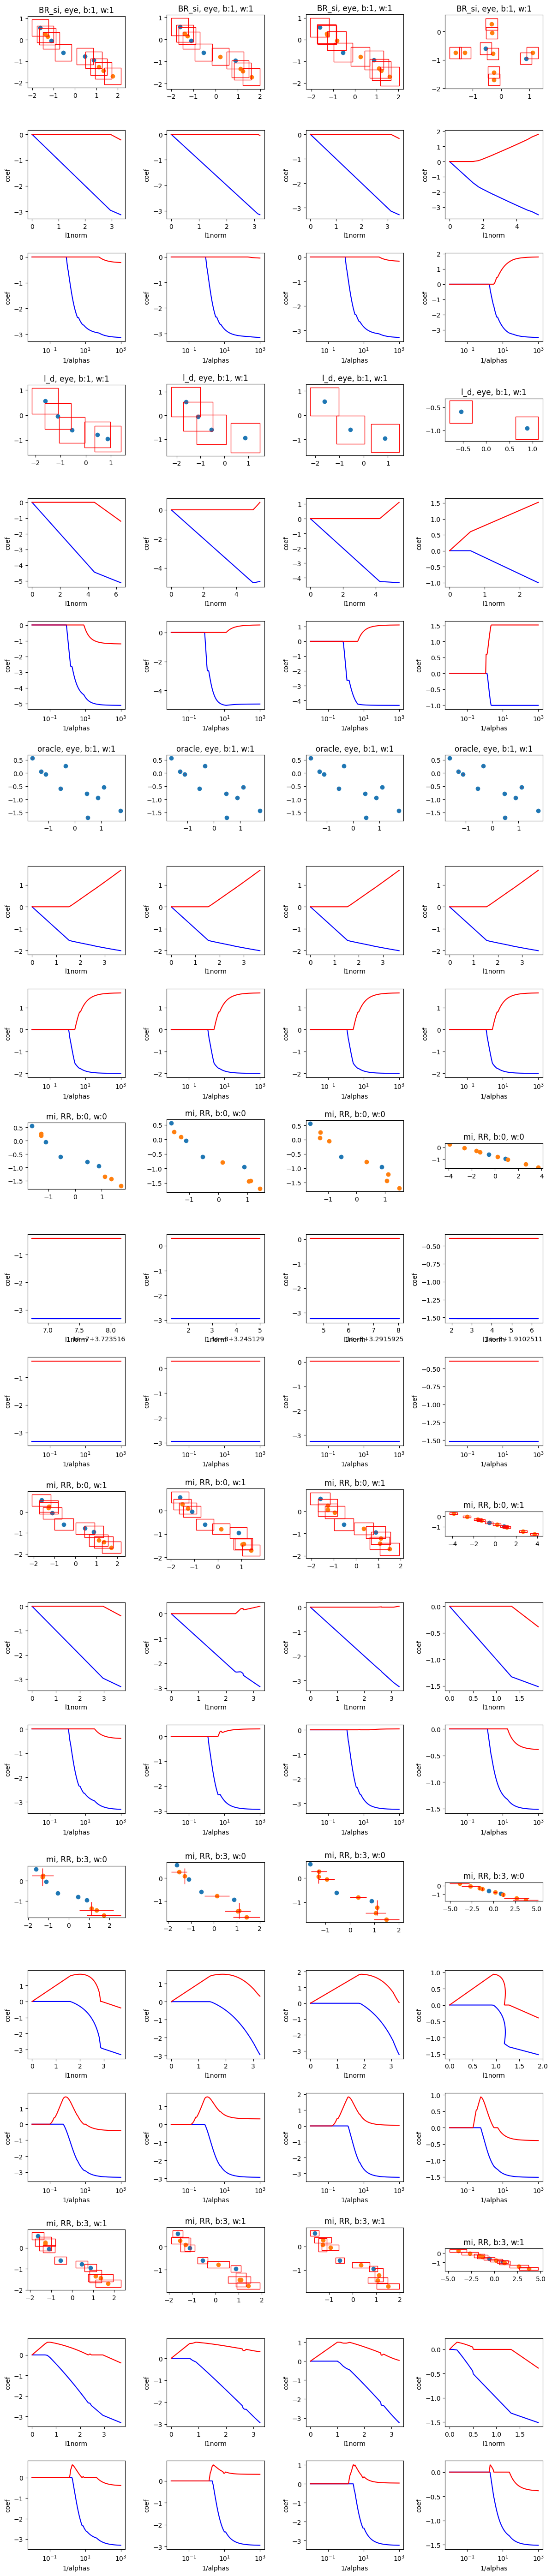

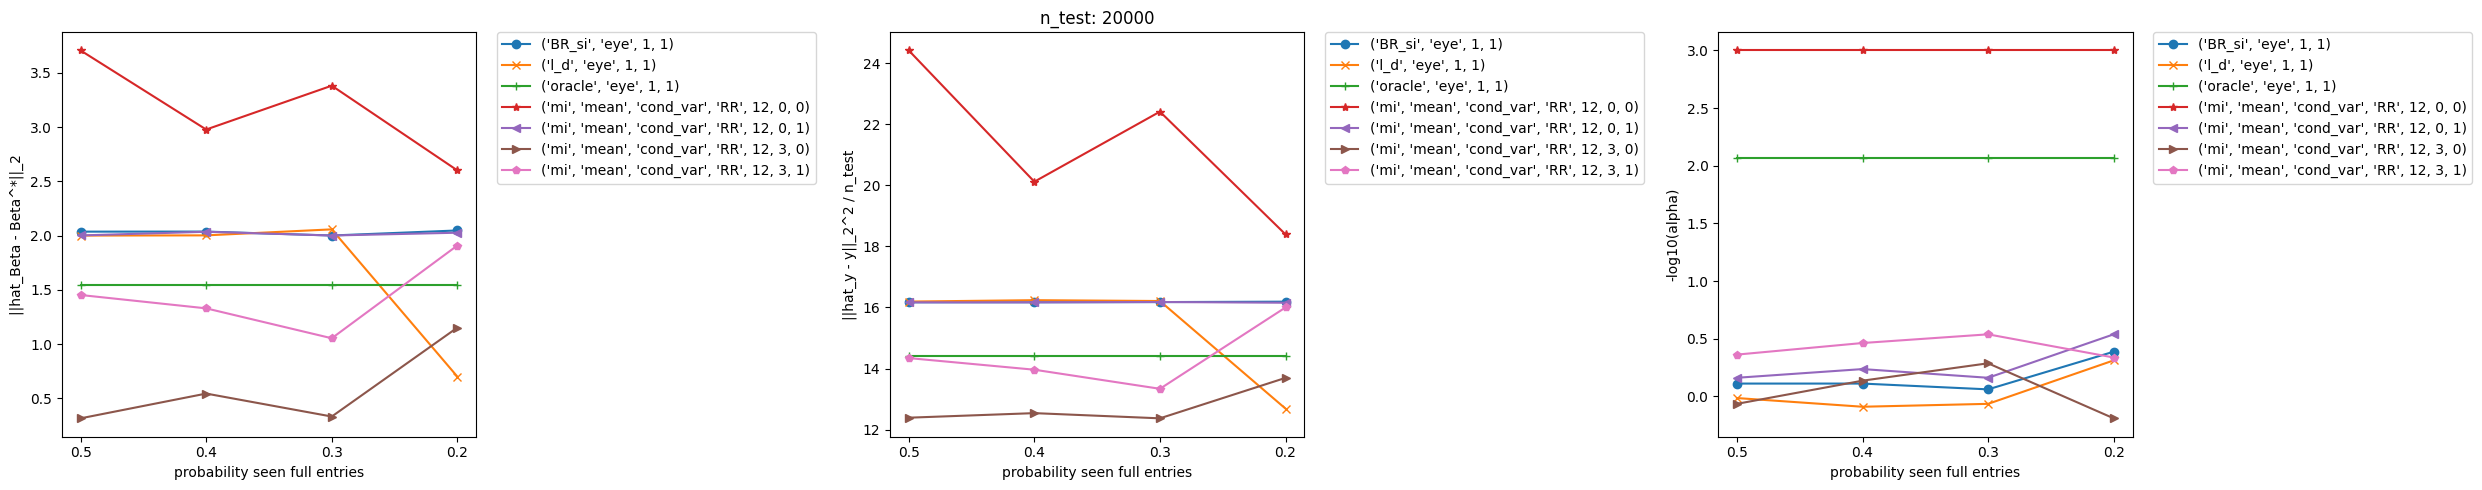

In [6]:
np.random.seed(456789)

#info_axis = 'train'
#n_train = [400, 800, 1200, 1600, 2000]
#p_seen = make_probabilities([0.8, 0.8, 0.8, 0.8, 0.8])
#main_vec = n_train if info_axis == 'train' else p_seen
#info_x_axis = make_info_axis(main_vec, info_axis)

gen = 'fixed'
info_axis = 'p_seen'  # train or p_seen
#p_seen_both = [1, 0.95, 0.90, 0.85, 0.80, 0.75, 0.70, 0.65, 0.60, 0.55, 0.50, 0.45, 0.40, 0.35, 0.3, 0.25, 0.2, 0.15, 0.1, 0.05, 0.02]
#p_seen_both = [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]
p_seen_both = [0.5, 0.4, 0.3, 0.2]
#p_seen_both = [0.1]
#p_seen_both = [1, 0.9, 0.8]
length_vec = len(p_seen_both)
#n_train = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]
n_train = [10] * length_vec
error_vec =  [3.5] * length_vec
p_seen = make_probabilities(p_seen_both)
if info_axis == 'train':
  main_vec = n_train
elif info_axis == 'p_seen':
  main_vec = p_seen_both
elif info_axis == 'error':
  main_vec = error_vec
#main_vec = n_train if info_axis == 'train' else p_seen_both
info_x_axis = make_info_axis(main_vec, info_axis)


dicc = make_dictionary_data(
    nbr_experiments= len(main_vec), n_train = n_train, n_test=20000,
    data = {'data': 'Normal', 'mean': np.array([0, 0]), 'cov': np.array([[1, -0.1], [-0.1, 1]])},
    beta_gt = np.array([-0.5, 2]),
    p_miss = p_seen,
    err_vector = ['Gaussian_on_y', error_vec],
)
dicc = dicc | {'generation':gen}
for key, value in dicc.items():
  print(key,": " , value[0])

# (imp method, cov strategy, mi_nbr)
#list_imp_cov_methods = [('BR_si', 'sd'), ('l_d', 'sd'), ('mi', 'sd', 1)]

#list_methods_strategy = make_dictionary_method(list_imp_cov_methods)
mi_nbr = 12
list_methods_strategy = [{'imp_method': 'BR_si', 'cov_strategy': 'eye', 'multip_dataset': 1, 'multip_missing':1},
                        {'imp_method': 'l_d', 'cov_strategy': 'eye', 'multip_dataset': 1, 'multip_missing':1},
                        {'imp_method': 'oracle', 'cov_strategy': 'eye', 'multip_dataset': 1, 'multip_missing':1},
                        #{'imp_method': 'mi', 'cov_strategy': 'RR', 'mi_nbr': 1},
                        #{'imp_method': 'mi', 'cov_strategy': 'RR', 'mi_nbr': 3},
                        #{'imp_method': 'mi_pure', 'cov_strategy': 'eye', 'mi_nbr': 2},
                        #{'imp_method': 'mi_pure', 'cov_strategy': 'cond_var', 'cov_strategy_within': 'sd', 'mi_nbr': 5},
                        #{'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'zero', 'mi_nbr': mi_nbr, 'multip_betw': 1, 'multip_with': 1},
                        #{'imp_method': 'mi_mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'eye', 'mi_nbr': 5},
                        #{'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'zero', 'mi_nbr': mi_nbr, 'multip_betw': 0, 'multip_with': 0},
                        #{'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'RR', 'mi_nbr': mi_nbr, 'multip_betw': 1, 'multip_with': 0.2},
                        #{'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'RR', 'mi_nbr': mi_nbr, 'multip_betw': 1, 'multip_with': 0.4},
                        #{'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'RR', 'mi_nbr': mi_nbr, 'multip_betw': 1, 'multip_with': 0.6},
                        {'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'RR', 'mi_nbr': mi_nbr, 'multip_dataset': 0, 'multip_missing': 0},
                        {'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'RR', 'mi_nbr': mi_nbr, 'multip_dataset': 0, 'multip_missing': 1},
                        {'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'RR', 'mi_nbr': mi_nbr, 'multip_dataset': 3, 'multip_missing': 0},
                        {'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'RR', 'mi_nbr': mi_nbr, 'multip_dataset': 3, 'multip_missing': 1},
                        #{'imp_method': 'mi', 'cov_strategy': 'RR', 'mi_nbr': 5},
                        ]
print(list_methods_strategy)
for el in list_methods_strategy:
  for key, value in el.items():
    print(key,": " , value)

print("----> Starting experiments")
res = run_experiments(dicc, list_methods_strategy)
plot_res(info_x_axis, res, dicc)



## you can see if you manage to take the index i that maximize alpha



change nbr_experiments to match the size of n_train
data :  {'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[ 1. , -0.1],
       [-0.1,  1. ]])}
n_tot :  20050
n_train :  50
n_test :  20000
dim :  2
beta_gt :  [-0.5  2. ]
perc_test :  0.9975062344139651
err :  {'type': 'Gaussian_on_y', 'scaling': 1}
p_miss :  [1, 0.0, 0.0]
generation :  f
[{'imp_method': 'BR_si', 'cov_strategy': 'eye', 'multip_betw': 1, 'multip_with': 1}, {'imp_method': 'l_d', 'cov_strategy': 'eye', 'multip_betw': 1, 'multip_with': 1}, {'imp_method': 'oracle', 'cov_strategy': 'eye', 'multip_betw': 1, 'multip_with': 1}, {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'RR', 'mi_nbr': 30, 'multip_betw': 0, 'multip_with': 0}, {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'RR', 'mi_nbr': 30, 'multip_betw': 0, 'multip_with': 1}, {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'RR', 

100%|██████████| 200/200 [00:00<00:00, 238.11it/s]


------------------------> who is S in add_rectangles
 [[0.02025502 0.        ]
 [0.         0.02025502]]
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  52  best 1/best_alpha  49.37047852839001 , min score  1.0839662396067562
---------------------------------> best coeff  [-0.48411811  1.72582052]
BR_si
eye
1
1
----------------------------------------------> new method tested:  {'imp_method': 'l_d', 'cov_strategy': 'eye', 'multip_betw': 1, 'multip_with': 1}
-------> ORACLE SD [1.22790322 0.98841344]
crush test------------------------------------------------->  -0.09643843491769896
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S within 
 [[1. 0.]
 [0. 1.]]
final S 
 [[1. 0.]
 [0. 1.]]
shape X_imputed in post_imputation  (50, 2)
y_train length  50
-------> size test:  20000  , size train:  50 nbr_seen (train):  50  nbr_miss :  0
X  

100%|██████████| 200/200 [00:00<00:00, 311.99it/s]


------------------------> who is S in add_rectangles
 [[0.02025502 0.        ]
 [0.         0.02025502]]
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  52  best 1/best_alpha  49.37047852839001 , min score  1.0839662396067562
---------------------------------> best coeff  [-0.48411811  1.72582052]
l_d
eye
1
1
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'eye', 'multip_betw': 1, 'multip_with': 1}
-------> ORACLE SD [1.22790322 0.98841344]
crush test------------------------------------------------->  -0.09643843491769896
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S within 
 [[1. 0.]
 [0. 1.]]
final S 
 [[1. 0.]
 [0. 1.]]
shape X_imputed in post_imputation  (50, 2)
y_train length  50
-------> size test:  20000  , size train:  50 nbr_seen (train):  50  nbr_miss :  0
X 

100%|██████████| 200/200 [00:00<00:00, 306.77it/s]


------------------------> who is S in add_rectangles
 [[0.02025502 0.        ]
 [0.         0.02025502]]
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  52  best 1/best_alpha  49.37047852839001 , min score  1.0839662396067562
---------------------------------> best coeff  [-0.48411811  1.72582052]
oracle
eye
1
1
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'RR', 'mi_nbr': 30, 'multip_betw': 0, 'multip_with': 0}
-------> ORACLE SD [1.22790322 0.98841344]
crush test------------------------------------------------->  -2.893153047531018
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
s_within  [1.22790322 0.98841344]
cov computed
s_between  [2.22044605e-16 4.44089210e-16]
final S in cov strategy RR  [[1.22790322 0.        ]
 [0.         0.98841344]]
S within 
 [[1.22790322

100%|██████████| 200/200 [00:00<00:00, 240.74it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best 1/best_alpha  1000.0 , min score  1.0729721802596057
---------------------------------> best coeff  [-0.49081702  1.74541476]
mi
mean
cond_var
RR
30
0
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'RR', 'mi_nbr': 30, 'multip_betw': 0, 'multip_with': 1}
-------> ORACLE SD [1.22790322 0.98841344]
crush test------------------------------------------------->  -2.893153047531018
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
s_within  [1.22790322 0.98841344]
cov computed
s_between  [2.22044605e-16 4.44089210e-16]
final S in cov strategy RR  [[1.22790322 0.        ]
 [0.         0.98841344]]
S within 
 [[1.22790322 0.        ]
 [0.         0.98841344]]
shape X_imputed in post_imputation  (30, 50, 2)
y_train length  50

100%|██████████| 200/200 [00:00<00:00, 205.94it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  52  best 1/best_alpha  49.37047852839001 , min score  1.0840747066440963
---------------------------------> best coeff  [-0.48176214  1.7259404 ]
mi
mean
cond_var
RR
30
0
1
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'RR', 'mi_nbr': 30, 'multip_betw': 3, 'multip_with': 0}
-------> ORACLE SD [1.22790322 0.98841344]
crush test------------------------------------------------->  -2.893153047531018
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
s_within  [1.22790322 0.98841344]
cov computed
s_between  [2.22044605e-16 4.44089210e-16]
final S in cov strategy RR  [[1.22790322 0.        ]
 [0.         0.98841344]]
S within 
 [[1.22790322 0.        ]
 [0.         0.98841344]]
shape X_imputed in post_imputation  (30, 50, 2)
y_trai

100%|██████████| 200/200 [00:00<00:00, 234.51it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best 1/best_alpha  1000.0 , min score  1.0729721802596057
---------------------------------> best coeff  [-0.49081702  1.74541476]
mi
mean
cond_var
RR
30
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'RR', 'mi_nbr': 30, 'multip_betw': 3, 'multip_with': 1}
-------> ORACLE SD [1.22790322 0.98841344]
crush test------------------------------------------------->  -2.893153047531018
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
s_within  [1.22790322 0.98841344]
cov computed
s_between  [2.22044605e-16 4.44089210e-16]
final S in cov strategy RR  [[1.22790322 0.        ]
 [0.         0.98841344]]
S within 
 [[1.22790322 0.        ]
 [0.         0.98841344]]
shape X_imputed in post_imputation  (30, 50, 2)
y_train length  50

100%|██████████| 200/200 [00:00<00:00, 202.71it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  52  best 1/best_alpha  49.37047852839001 , min score  1.0840747066440963
---------------------------------> best coeff  [-0.48176214  1.7259404 ]
mi
mean
cond_var
RR
30
3
1
---------------------------------------------------------------------------------------------------------------------------> iteration  1
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[ 1. , -0.1],
       [-0.1,  1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'eye', 'multip_betw': 1, 'multip_with': 1}
-------> ORACLE SD [1.22790322 0.98841344]
crush test------------------------------------------------->  2.007193367560859
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1]
S within 
 [[1. 0.]
 [0. 1.]]
final S 
 [[1. 0.]
 [0. 1.]]
shape X_imputed in post_imputation  (50, 2)
y_train

100%|██████████| 200/200 [00:00<00:00, 277.40it/s]


------------------------> who is S in add_rectangles
 [[0.01431459 0.        ]
 [0.         0.01431459]]
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  46  best 1/best_alpha  69.85879746785245 , min score  1.1013394821775995
---------------------------------> best coeff  [-0.44530374  1.70358854]
BR_si
eye
1
1
----------------------------------------------> new method tested:  {'imp_method': 'l_d', 'cov_strategy': 'eye', 'multip_betw': 1, 'multip_with': 1}
-------> ORACLE SD [1.22790322 0.98841344]
crush test------------------------------------------------->  2.4329110256081634
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
S within 
 [[1. 0.]
 [0. 1.]]
final S 
 [[1. 0.]
 [0. 1.]]
shape X_imputed in post_imputation  (45, 2)
y_train length  45
-------> size test:  20000  , size train:  45 nbr_seen (train):  45  nbr_miss :  0
X  45 2
Shape  (2, 2)

100%|██████████| 200/200 [00:01<00:00, 199.79it/s]


------------------------> who is S in add_rectangles
 [[0.02025502 0.        ]
 [0.         0.02025502]]
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  52  best 1/best_alpha  49.37047852839001 , min score  1.0902418450986273
---------------------------------> best coeff  [-0.53058805  1.71255944]
l_d
eye
1
1
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'eye', 'multip_betw': 1, 'multip_with': 1}
-------> ORACLE SD [1.22790322 0.98841344]
crush test------------------------------------------------->  -0.09643843491769896
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S within 
 [[1. 0.]
 [0. 1.]]
final S 
 [[1. 0.]
 [0. 1.]]
shape X_imputed in post_imputation  (50, 2)
y_train length  50
-------> size test:  20000  , size train:  50 nbr_seen (train):  50  nbr_miss :  0
X 

100%|██████████| 200/200 [00:01<00:00, 192.74it/s]


------------------------> who is S in add_rectangles
 [[0.02025502 0.        ]
 [0.         0.02025502]]
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  52  best 1/best_alpha  49.37047852839001 , min score  1.0839662396067562
---------------------------------> best coeff  [-0.48411811  1.72582052]
oracle
eye
1
1
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'RR', 'mi_nbr': 30, 'multip_betw': 0, 'multip_with': 0}
-------> ORACLE SD [1.22790322 0.98841344]
crush test------------------------------------------------->  60.236584728833776
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1]
s_within  [1.24226369 0.9719711 ]
cov computed
s_between  [0.01700641 0.0144184 ]
final S in cov strategy RR  [[1.25983698 0.        ]
 [0.         0.98687012]]
S within 
 [[1.25983698 0.     

100%|██████████| 200/200 [00:00<00:00, 243.54it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best 1/best_alpha  1000.0 , min score  1.0891861912863199
---------------------------------> best coeff  [-0.45398158  1.72205523]
mi
mean
cond_var
RR
30
0
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'RR', 'mi_nbr': 30, 'multip_betw': 0, 'multip_with': 1}
-------> ORACLE SD [1.22790322 0.98841344]
crush test------------------------------------------------->  60.236584728833776
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1]
s_within  [1.24226369 0.9719711 ]
cov computed
s_between  [0.01700641 0.0144184 ]
final S in cov strategy RR  [[1.25983698 0.        ]
 [0.         0.98687012]]
S within 
 [[1.25983698 0.        ]
 [0.         0.98687012]]
shape X_imputed in post_imputation  (30, 50, 2)
y_train length  50
-------

100%|██████████| 200/200 [00:00<00:00, 209.93it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  46  best 1/best_alpha  69.85879746785245 , min score  1.0999534537445466
---------------------------------> best coeff  [-0.44733401  1.70536334]
mi
mean
cond_var
RR
30
0
1
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'RR', 'mi_nbr': 30, 'multip_betw': 3, 'multip_with': 0}
-------> ORACLE SD [1.22790322 0.98841344]
crush test------------------------------------------------->  60.236584728833776
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1]
s_within  [1.24226369 0.9719711 ]
cov computed
s_between  [0.01700641 0.0144184 ]
final S in cov strategy RR  [[1.25983698 0.        ]
 [0.         0.98687012]]
S within 
 [[1.25983698 0.        ]
 [0.         0.98687012]]
shape X_imputed in post_imputation  (30, 50, 2)
y_train length

100%|██████████| 200/200 [00:01<00:00, 177.93it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  63  best 1/best_alpha  26.126752255633274 , min score  1.0996176796841874
---------------------------------> best coeff  [-0.44585668  1.70628609]
mi
mean
cond_var
RR
30
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'RR', 'mi_nbr': 30, 'multip_betw': 3, 'multip_with': 1}
-------> ORACLE SD [1.22790322 0.98841344]
crush test------------------------------------------------->  60.236584728833776
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1]
s_within  [1.24226369 0.9719711 ]
cov computed
s_between  [0.01700641 0.0144184 ]
final S in cov strategy RR  [[1.25983698 0.        ]
 [0.         0.98687012]]
S within 
 [[1.25983698 0.        ]
 [0.         0.98687012]]
shape X_imputed in post_imputation  (30, 50, 2)
y_train lengt

100%|██████████| 200/200 [00:01<00:00, 127.16it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  42  best 1/best_alpha  88.0488358164346 , min score  1.1007099913145595
---------------------------------> best coeff  [-0.44632686  1.70436622]
mi
mean
cond_var
RR
30
3
1
---------------------------------------------------------------------------------------------------------------------------> iteration  2
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[ 1. , -0.1],
       [-0.1,  1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'eye', 'multip_betw': 1, 'multip_with': 1}
-------> ORACLE SD [1.22790322 0.98841344]
crush test------------------------------------------------->  0.20930921370446076
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 1 1 1 1 1 1 1 1 1]
S within 
 [[1. 0.]
 [0. 1.]]
final S 
 [[1. 0.]
 [0. 1.]]
shape X_imputed in post_imputation  (50, 2)
y_trai

100%|██████████| 200/200 [00:00<00:00, 256.27it/s]


------------------------> who is S in add_rectangles
 [[0.01431459 0.        ]
 [0.         0.01431459]]
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  46  best 1/best_alpha  69.85879746785245 , min score  1.0896928320793562
---------------------------------> best coeff  [-0.47363853  1.71728292]
BR_si
eye
1
1
----------------------------------------------> new method tested:  {'imp_method': 'l_d', 'cov_strategy': 'eye', 'multip_betw': 1, 'multip_with': 1}
-------> ORACLE SD [1.22790322 0.98841344]
crush test------------------------------------------------->  4.10308421739518
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
S within 
 [[1. 0.]
 [0. 1.]]
final S 
 [[1. 0.]
 [0. 1.]]
shape X_imputed in post_imputation  (40, 2)
y_train length  40
-------> size test:  20000  , size train:  40 nbr_seen (train):  40  nbr_miss :  0
X  40 2
Shape  (2, 2)
nm  80
one matri

100%|██████████| 200/200 [00:00<00:00, 323.98it/s]


------------------------> who is S in add_rectangles
 [[0.02025502 0.        ]
 [0.         0.02025502]]
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  52  best 1/best_alpha  49.37047852839001 , min score  1.0828204286134258
---------------------------------> best coeff  [-0.51376536  1.72560982]
l_d
eye
1
1
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'eye', 'multip_betw': 1, 'multip_with': 1}
-------> ORACLE SD [1.22790322 0.98841344]
crush test------------------------------------------------->  -0.09643843491769896
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S within 
 [[1. 0.]
 [0. 1.]]
final S 
 [[1. 0.]
 [0. 1.]]
shape X_imputed in post_imputation  (50, 2)
y_train length  50
-------> size test:  20000  , size train:  50 nbr_seen (train):  50  nbr_miss :  0
X 

100%|██████████| 200/200 [00:00<00:00, 295.38it/s]


------------------------> who is S in add_rectangles
 [[0.02025502 0.        ]
 [0.         0.02025502]]
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  52  best 1/best_alpha  49.37047852839001 , min score  1.0839662396067562
---------------------------------> best coeff  [-0.48411811  1.72582052]
oracle
eye
1
1
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'RR', 'mi_nbr': 30, 'multip_betw': 0, 'multip_with': 0}
-------> ORACLE SD [1.22790322 0.98841344]
crush test------------------------------------------------->  2.210969194543221
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 1 1 1 1 1 1 1 1 1]
s_within  [1.25523164 1.00712161]
cov computed
s_between  [0.02038961 0.03329583]
final S in cov strategy RR  [[1.27630091 0.        ]
 [0.         1.0415273 ]]
S within 
 [[1.27630091 0.      

100%|██████████| 200/200 [00:01<00:00, 170.94it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best 1/best_alpha  1000.0 , min score  1.070733224183045
---------------------------------> best coeff  [-0.48706737  1.75018682]
mi
mean
cond_var
RR
30
0
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'RR', 'mi_nbr': 30, 'multip_betw': 0, 'multip_with': 1}
-------> ORACLE SD [1.22790322 0.98841344]
crush test------------------------------------------------->  2.210969194543221
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 1 1 1 1 1 1 1 1 1]
s_within  [1.25523164 1.00712161]
cov computed
s_between  [0.02038961 0.03329583]
final S in cov strategy RR  [[1.27630091 0.        ]
 [0.         1.0415273 ]]
S within 
 [[1.27630091 0.        ]
 [0.         1.0415273 ]]
shape X_imputed in post_imputation  (30, 50, 2)
y_train length  50
-------> 

100%|██████████| 200/200 [00:01<00:00, 127.10it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  46  best 1/best_alpha  69.85879746785245 , min score  1.0816254531336094
---------------------------------> best coeff  [-0.47959965  1.73066074]
mi
mean
cond_var
RR
30
0
1
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'RR', 'mi_nbr': 30, 'multip_betw': 3, 'multip_with': 0}
-------> ORACLE SD [1.22790322 0.98841344]
crush test------------------------------------------------->  2.210969194543221
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 1 1 1 1 1 1 1 1 1]
s_within  [1.25523164 1.00712161]
cov computed
s_between  [0.02038961 0.03329583]
final S in cov strategy RR  [[1.27630091 0.        ]
 [0.         1.0415273 ]]
S within 
 [[1.27630091 0.        ]
 [0.         1.0415273 ]]
shape X_imputed in post_imputation  (30, 50, 2)
y_train length 

100%|██████████| 200/200 [00:00<00:00, 226.54it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  54  best 1/best_alpha  43.97603609302719 , min score  1.0815301800717187
---------------------------------> best coeff  [-0.48471309  1.73013492]
mi
mean
cond_var
RR
30
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'RR', 'mi_nbr': 30, 'multip_betw': 3, 'multip_with': 1}
-------> ORACLE SD [1.22790322 0.98841344]
crush test------------------------------------------------->  2.210969194543221
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 1 1 1 1 1 1 1 1 1]
s_within  [1.25523164 1.00712161]
cov computed
s_between  [0.02038961 0.03329583]
final S in cov strategy RR  [[1.27630091 0.        ]
 [0.         1.0415273 ]]
S within 
 [[1.27630091 0.        ]
 [0.         1.0415273 ]]
shape X_imputed in post_imputation  (30, 50, 2)
y_train length 

100%|██████████| 200/200 [00:00<00:00, 202.62it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best 1/best_alpha  104.73708979594498 , min score  1.0823826881244671
---------------------------------> best coeff  [-0.48111263  1.7290722 ]
mi
mean
cond_var
RR
30
3
1
---------------------------------------------------------------------------------------------------------------------------> iteration  3
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[ 1. , -0.1],
       [-0.1,  1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'eye', 'multip_betw': 1, 'multip_with': 1}
-------> ORACLE SD [1.22790322 0.98841344]
crush test------------------------------------------------->  -0.7466425264544853
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S within 
 [[1. 0.]
 [0. 1.]]
final S 
 [[1. 0.]
 [0. 1.]]
shape X_imputed in post_imputation  (50, 2)
y_tr

100%|██████████| 200/200 [00:00<00:00, 303.33it/s]


------------------------> who is S in add_rectangles
 [[0.01350994 0.        ]
 [0.         0.01350994]]
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  45  best 1/best_alpha  74.0195999691564 , min score  1.1046233205782992
---------------------------------> best coeff  [-0.55125732  1.68974446]
BR_si
eye
1
1
----------------------------------------------> new method tested:  {'imp_method': 'l_d', 'cov_strategy': 'eye', 'multip_betw': 1, 'multip_with': 1}
-------> ORACLE SD [1.22790322 0.98841344]
crush test------------------------------------------------->  9.804616233939843
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
S within 
 [[1. 0.]
 [0. 1.]]
final S 
 [[1. 0.]
 [0. 1.]]
shape X_imputed in post_imputation  (35, 2)
y_train length  35
-------> size test:  20000  , size train:  35 nbr_seen (train):  35  nbr_miss :  0
X  35 2
Shape  (2, 2)
nm  70
one matrix in input, S.s

100%|██████████| 200/200 [00:00<00:00, 347.10it/s]


------------------------> who is S in add_rectangles
 [[0.02146141 0.        ]
 [0.         0.02146141]]
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  53  best 1/best_alpha  46.5952566866468 , min score  1.0609623138474649
---------------------------------> best coeff  [-0.48793896  1.76996506]
l_d
eye
1
1
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'eye', 'multip_betw': 1, 'multip_with': 1}
-------> ORACLE SD [1.22790322 0.98841344]
crush test------------------------------------------------->  -0.09643843491769896
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S within 
 [[1. 0.]
 [0. 1.]]
final S 
 [[1. 0.]
 [0. 1.]]
shape X_imputed in post_imputation  (50, 2)
y_train length  50
-------> size test:  20000  , size train:  50 nbr_seen (train):  50  nbr_miss :  0
X  

100%|██████████| 200/200 [00:00<00:00, 301.12it/s]


------------------------> who is S in add_rectangles
 [[0.02025502 0.        ]
 [0.         0.02025502]]
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  52  best 1/best_alpha  49.37047852839001 , min score  1.0839662396067562
---------------------------------> best coeff  [-0.48411811  1.72582052]
oracle
eye
1
1
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'RR', 'mi_nbr': 30, 'multip_betw': 0, 'multip_with': 0}
-------> ORACLE SD [1.22790322 0.98841344]
crush test------------------------------------------------->  -5.513794655371985
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
s_within  [1.282209   1.00590214]
cov computed
s_between  [0.04420162 0.04432297]
final S in cov strategy RR  [[1.32788401 0.        ]
 [0.         1.05170255]]
S within 
 [[1.32788401 0.     

100%|██████████| 200/200 [00:00<00:00, 234.04it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best 1/best_alpha  1000.0 , min score  1.0727090626921443
---------------------------------> best coeff  [-0.55424913  1.74693896]
mi
mean
cond_var
RR
30
0
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'RR', 'mi_nbr': 30, 'multip_betw': 0, 'multip_with': 1}
-------> ORACLE SD [1.22790322 0.98841344]
crush test------------------------------------------------->  -5.513794655371985
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
s_within  [1.282209   1.00590214]
cov computed
s_between  [0.04420162 0.04432297]
final S in cov strategy RR  [[1.32788401 0.        ]
 [0.         1.05170255]]
S within 
 [[1.32788401 0.        ]
 [0.         1.05170255]]
shape X_imputed in post_imputation  (30, 50, 2)
y_train length  50
-------

100%|██████████| 200/200 [00:00<00:00, 203.63it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  46  best 1/best_alpha  69.85879746785245 , min score  1.0837813162656025
---------------------------------> best coeff  [-0.5435973   1.72476799]
mi
mean
cond_var
RR
30
0
1
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'RR', 'mi_nbr': 30, 'multip_betw': 3, 'multip_with': 0}
-------> ORACLE SD [1.22790322 0.98841344]
crush test------------------------------------------------->  -5.513794655371985
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
s_within  [1.282209   1.00590214]
cov computed
s_between  [0.04420162 0.04432297]
final S in cov strategy RR  [[1.32788401 0.        ]
 [0.         1.05170255]]
S within 
 [[1.32788401 0.        ]
 [0.         1.05170255]]
shape X_imputed in post_imputation  (30, 50, 2)
y_train length

100%|██████████| 200/200 [00:00<00:00, 227.53it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  50  best 1/best_alpha  55.42664520663104 , min score  1.0836175599228208
---------------------------------> best coeff  [-0.55598573  1.72639724]
mi
mean
cond_var
RR
30
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'RR', 'mi_nbr': 30, 'multip_betw': 3, 'multip_with': 1}
-------> ORACLE SD [1.22790322 0.98841344]
crush test------------------------------------------------->  -5.513794655371985
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
s_within  [1.282209   1.00590214]
cov computed
s_between  [0.04420162 0.04432297]
final S in cov strategy RR  [[1.32788401 0.        ]
 [0.         1.05170255]]
S within 
 [[1.32788401 0.        ]
 [0.         1.05170255]]
shape X_imputed in post_imputation  (30, 50, 2)
y_train length

100%|██████████| 200/200 [00:01<00:00, 198.00it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  37  best 1/best_alpha  117.5849554052157 , min score  1.0843078556881194
---------------------------------> best coeff  [-0.54876853  1.72429443]
mi
mean
cond_var
RR
30
3
1
---------------------------------------------------------------------------------------------------------------------------> iteration  4
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[ 1. , -0.1],
       [-0.1,  1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'eye', 'multip_betw': 1, 'multip_with': 1}
-------> ORACLE SD [1.22790322 0.98841344]
crush test------------------------------------------------->  -4.047789802668278
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S within 
 [[1. 0.]
 [0. 1.]]
final S 
 [[1. 0.]
 [0. 1.]]
shape X_imputed in post_imputation  (50, 2)
y_trai

100%|██████████| 200/200 [00:00<00:00, 296.69it/s]


------------------------> who is S in add_rectangles
 [[0.01702769 0.        ]
 [0.         0.01702769]]
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  49  best 1/best_alpha  58.7278661318948 , min score  1.0868091655219556
---------------------------------> best coeff  [-0.58491344  1.7258529 ]
BR_si
eye
1
1
----------------------------------------------> new method tested:  {'imp_method': 'l_d', 'cov_strategy': 'eye', 'multip_betw': 1, 'multip_with': 1}
-------> ORACLE SD [1.22790322 0.98841344]
crush test------------------------------------------------->  -0.9913598981218077
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]
S within 
 [[1. 0.]
 [0. 1.]]
final S 
 [[1. 0.]
 [0. 1.]]
shape X_imputed in post_imputation  (30, 2)
y_train length  30
-------> size test:  20000  , size train:  30 nbr_seen (train):  30  nbr_miss :  0
X  30 2
Shape  (2, 2)
nm  60
one matrix in input, S.shape = (n, n)

100%|██████████| 200/200 [00:00<00:00, 367.93it/s]


------------------------> who is S in add_rectangles
 [[0.01431459 0.        ]
 [0.         0.01431459]]
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  46  best 1/best_alpha  69.85879746785245 , min score  1.1589043778312633
---------------------------------> best coeff  [-0.37446583  1.64250142]
l_d
eye
1
1
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'eye', 'multip_betw': 1, 'multip_with': 1}
-------> ORACLE SD [1.22790322 0.98841344]
crush test------------------------------------------------->  -0.09643843491769896
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S within 
 [[1. 0.]
 [0. 1.]]
final S 
 [[1. 0.]
 [0. 1.]]
shape X_imputed in post_imputation  (50, 2)
y_train length  50
-------> size test:  20000  , size train:  50 nbr_seen (train):  50  nbr_miss :  0
X 

100%|██████████| 200/200 [00:00<00:00, 298.96it/s]


------------------------> who is S in add_rectangles
 [[0.02025502 0.        ]
 [0.         0.02025502]]
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  52  best 1/best_alpha  49.37047852839001 , min score  1.0839662396067562
---------------------------------> best coeff  [-0.48411811  1.72582052]
oracle
eye
1
1
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'RR', 'mi_nbr': 30, 'multip_betw': 0, 'multip_with': 0}
-------> ORACLE SD [1.22790322 0.98841344]
crush test------------------------------------------------->  -153.31357294711006
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
s_within  [1.25883092 1.01587785]
cov computed
s_between  [0.03875704 0.04523212]
final S in cov strategy RR  [[1.29887986 0.        ]
 [0.         1.06261771]]
S within 
 [[1.29887986 0.    

100%|██████████| 200/200 [00:00<00:00, 238.16it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best 1/best_alpha  1000.0 , min score  1.0840879237749177
---------------------------------> best coeff  [-0.61098162  1.73876738]
mi
mean
cond_var
RR
30
0
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'RR', 'mi_nbr': 30, 'multip_betw': 0, 'multip_with': 1}
-------> ORACLE SD [1.22790322 0.98841344]
crush test------------------------------------------------->  -153.31357294711006
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
s_within  [1.25883092 1.01587785]
cov computed
s_between  [0.03875704 0.04523212]
final S in cov strategy RR  [[1.29887986 0.        ]
 [0.         1.06261771]]
S within 
 [[1.29887986 0.        ]
 [0.         1.06261771]]
shape X_imputed in post_imputation  (30, 50, 2)
y_train length  50
------

100%|██████████| 200/200 [00:00<00:00, 205.43it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  47  best 1/best_alpha  65.93188271333545 , min score  1.0949805590381383
---------------------------------> best coeff  [-0.5938234   1.71326248]
mi
mean
cond_var
RR
30
0
1
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'RR', 'mi_nbr': 30, 'multip_betw': 3, 'multip_with': 0}
-------> ORACLE SD [1.22790322 0.98841344]
crush test------------------------------------------------->  -153.31357294711006
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
s_within  [1.25883092 1.01587785]
cov computed
s_between  [0.03875704 0.04523212]
final S in cov strategy RR  [[1.29887986 0.        ]
 [0.         1.06261771]]
S within 
 [[1.29887986 0.        ]
 [0.         1.06261771]]
shape X_imputed in post_imputation  (30, 50, 2)
y_train lengt

100%|██████████| 200/200 [00:00<00:00, 220.04it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  43  best 1/best_alpha  83.09941949353392 , min score  1.0951319866002969
---------------------------------> best coeff  [-0.61048622  1.71781327]
mi
mean
cond_var
RR
30
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'RR', 'mi_nbr': 30, 'multip_betw': 3, 'multip_with': 1}
-------> ORACLE SD [1.22790322 0.98841344]
crush test------------------------------------------------->  -153.31357294711006
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
s_within  [1.25883092 1.01587785]
cov computed
s_between  [0.03875704 0.04523212]
final S in cov strategy RR  [[1.29887986 0.        ]
 [0.         1.06261771]]
S within 
 [[1.29887986 0.        ]
 [0.         1.06261771]]
shape X_imputed in post_imputation  (30, 50, 2)
y_train lengt

100%|██████████| 200/200 [00:00<00:00, 203.56it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  34  best 1/best_alpha  139.87131026472386 , min score  1.0956913084519908
---------------------------------> best coeff  [-0.60262444  1.71439859]
mi
mean
cond_var
RR
30
3
1
---------------------------------------------------------------------------------------------------------------------------> iteration  5
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[ 1. , -0.1],
       [-0.1,  1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'eye', 'multip_betw': 1, 'multip_with': 1}
-------> ORACLE SD [1.22790322 0.98841344]
crush test------------------------------------------------->  -7.022556395727712
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S within 
 [[1. 0.]
 [0. 1.]]
final S 
 [[1. 0.]
 [0. 1.]]
shape X_imputed in post_imputation  (50, 2)
y_tra

100%|██████████| 200/200 [00:00<00:00, 294.74it/s]


------------------------> who is S in add_rectangles
 [[0.01702769 0.        ]
 [0.         0.01702769]]
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  49  best 1/best_alpha  58.7278661318948 , min score  1.1084099162667969
---------------------------------> best coeff  [-0.62465124  1.69922437]
BR_si
eye
1
1
----------------------------------------------> new method tested:  {'imp_method': 'l_d', 'cov_strategy': 'eye', 'multip_betw': 1, 'multip_with': 1}
-------> ORACLE SD [1.22790322 0.98841344]
crush test------------------------------------------------->  -2.121041935369398
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
S within 
 [[1. 0.]
 [0. 1.]]
final S 
 [[1. 0.]
 [0. 1.]]
shape X_imputed in post_imputation  (25, 2)
y_train length  25
-------> size test:  20000  , size train:  25 nbr_seen (train):  25  nbr_miss :  0
X  25 2
Shape  (2, 2)
nm  50
one matrix in input, S.shape = (n, n)


100%|██████████| 200/200 [00:00<00:00, 375.13it/s]


------------------------> who is S in add_rectangles
 [[0.01702769 0.        ]
 [0.         0.01702769]]
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  49  best 1/best_alpha  58.7278661318948 , min score  1.0967981637807451
---------------------------------> best coeff  [-0.34498647  1.75556754]
l_d
eye
1
1
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'eye', 'multip_betw': 1, 'multip_with': 1}
-------> ORACLE SD [1.22790322 0.98841344]
crush test------------------------------------------------->  -0.09643843491769896
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S within 
 [[1. 0.]
 [0. 1.]]
final S 
 [[1. 0.]
 [0. 1.]]
shape X_imputed in post_imputation  (50, 2)
y_train length  50
-------> size test:  20000  , size train:  50 nbr_seen (train):  50  nbr_miss :  0
X  

100%|██████████| 200/200 [00:00<00:00, 309.82it/s]


------------------------> who is S in add_rectangles
 [[0.02025502 0.        ]
 [0.         0.02025502]]
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  52  best 1/best_alpha  49.37047852839001 , min score  1.0839662396067562
---------------------------------> best coeff  [-0.48411811  1.72582052]
oracle
eye
1
1
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'RR', 'mi_nbr': 30, 'multip_betw': 0, 'multip_with': 0}
-------> ORACLE SD [1.22790322 0.98841344]
crush test------------------------------------------------->  -210.51239131474136
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
s_within  [1.30370837 1.02997866]
cov computed
s_between  [0.05539182 0.04648216]
final S in cov strategy RR  [[1.36094658 0.        ]
 [0.         1.07801022]]
S within 
 [[1.36094658 0.    

100%|██████████| 200/200 [00:00<00:00, 244.70it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best 1/best_alpha  1000.0 , min score  1.0832267213312703
---------------------------------> best coeff  [-0.61571609  1.74222457]
mi
mean
cond_var
RR
30
0
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'RR', 'mi_nbr': 30, 'multip_betw': 0, 'multip_with': 1}
-------> ORACLE SD [1.22790322 0.98841344]
crush test------------------------------------------------->  -210.51239131474136
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
s_within  [1.30370837 1.02997866]
cov computed
s_between  [0.05539182 0.04648216]
final S in cov strategy RR  [[1.36094658 0.        ]
 [0.         1.07801022]]
S within 
 [[1.36094658 0.        ]
 [0.         1.07801022]]
shape X_imputed in post_imputation  (30, 50, 2)
y_train length  50
------

100%|██████████| 200/200 [00:00<00:00, 208.16it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  48  best 1/best_alpha  62.22570836730229 , min score  1.0945056487361207
---------------------------------> best coeff  [-0.59618349  1.71472395]
mi
mean
cond_var
RR
30
0
1
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'RR', 'mi_nbr': 30, 'multip_betw': 3, 'multip_with': 0}
-------> ORACLE SD [1.22790322 0.98841344]
crush test------------------------------------------------->  -210.51239131474136
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
s_within  [1.30370837 1.02997866]
cov computed
s_between  [0.05539182 0.04648216]
final S in cov strategy RR  [[1.36094658 0.        ]
 [0.         1.07801022]]
S within 
 [[1.36094658 0.        ]
 [0.         1.07801022]]
shape X_imputed in post_imputation  (30, 50, 2)
y_train lengt

100%|██████████| 200/200 [00:00<00:00, 227.90it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  40  best 1/best_alpha  98.84959046625582 , min score  1.094410136545183
---------------------------------> best coeff  [-0.61603925  1.7209965 ]
mi
mean
cond_var
RR
30
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'RR', 'mi_nbr': 30, 'multip_betw': 3, 'multip_with': 1}
-------> ORACLE SD [1.22790322 0.98841344]
crush test------------------------------------------------->  -210.51239131474136
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
s_within  [1.30370837 1.02997866]
cov computed
s_between  [0.05539182 0.04648216]
final S in cov strategy RR  [[1.36094658 0.        ]
 [0.         1.07801022]]
S within 
 [[1.36094658 0.        ]
 [0.         1.07801022]]
shape X_imputed in post_imputation  (30, 50, 2)
y_train length

100%|██████████| 200/200 [00:00<00:00, 200.51it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  33  best 1/best_alpha  148.20207057988586 , min score  1.0953259235880988
---------------------------------> best coeff  [-0.60775947  1.71659721]
mi
mean
cond_var
RR
30
3
1
---------------------------------------------------------------------------------------------------------------------------> iteration  6
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[ 1. , -0.1],
       [-0.1,  1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'eye', 'multip_betw': 1, 'multip_with': 1}
-------> ORACLE SD [1.22790322 0.98841344]
crush test------------------------------------------------->  -12.577791789099805
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S within 
 [[1. 0.]
 [0. 1.]]
final S 
 [[1. 0.]
 [0. 1.]]
shape X_imputed in post_imputation  (50, 2)
y_tr

100%|██████████| 200/200 [00:00<00:00, 293.85it/s]


------------------------> who is S in add_rectangles
 [[0.0270496 0.       ]
 [0.        0.0270496]]
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  57  best 1/best_alpha  36.96912707195027 , min score  1.0900572230926548
---------------------------------> best coeff  [-0.64248809  1.74034545]
BR_si
eye
1
1
----------------------------------------------> new method tested:  {'imp_method': 'l_d', 'cov_strategy': 'eye', 'multip_betw': 1, 'multip_with': 1}
-------> ORACLE SD [1.22790322 0.98841344]
crush test------------------------------------------------->  -4.808054524578064
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
S within 
 [[1. 0.]
 [0. 1.]]
final S 
 [[1. 0.]
 [0. 1.]]
shape X_imputed in post_imputation  (20, 2)
y_train length  20
-------> size test:  20000  , size train:  20 nbr_seen (train):  20  nbr_miss :  0
X  20 2
Shape  (2, 2)
nm  40
one matrix in input, S.shape = (n, n)


100%|██████████| 200/200 [00:00<00:00, 315.82it/s]


------------------------> who is S in add_rectangles
 [[0.02866068 0.        ]
 [0.         0.02866068]]
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  58  best 1/best_alpha  34.891012134067715 , min score  1.0545594855780929
---------------------------------> best coeff  [-0.27479378  1.97722665]
l_d
eye
1
1
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'eye', 'multip_betw': 1, 'multip_with': 1}
-------> ORACLE SD [1.22790322 0.98841344]
crush test------------------------------------------------->  -0.09643843491769896
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S within 
 [[1. 0.]
 [0. 1.]]
final S 
 [[1. 0.]
 [0. 1.]]
shape X_imputed in post_imputation  (50, 2)
y_train length  50
-------> size test:  20000  , size train:  50 nbr_seen (train):  50  nbr_miss :  0
X

100%|██████████| 200/200 [00:01<00:00, 196.05it/s]


------------------------> who is S in add_rectangles
 [[0.02025502 0.        ]
 [0.         0.02025502]]
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  52  best 1/best_alpha  49.37047852839001 , min score  1.0839662396067562
---------------------------------> best coeff  [-0.48411811  1.72582052]
oracle
eye
1
1
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'RR', 'mi_nbr': 30, 'multip_betw': 0, 'multip_with': 0}
-------> ORACLE SD [1.22790322 0.98841344]
crush test------------------------------------------------->  -423.6280121022978
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
s_within  [1.2713758  1.01579568]
cov computed
s_between  [0.05461283 0.04304538]
final S in cov strategy RR  [[1.32780906 0.        ]
 [0.         1.06027591]]
S within 
 [[1.32780906 0.     

100%|██████████| 200/200 [00:00<00:00, 239.93it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best 1/best_alpha  1000.0 , min score  1.090349213214275
---------------------------------> best coeff  [-0.59698965  1.7224617 ]
mi
mean
cond_var
RR
30
0
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'RR', 'mi_nbr': 30, 'multip_betw': 0, 'multip_with': 1}
-------> ORACLE SD [1.22790322 0.98841344]
crush test------------------------------------------------->  -423.6280121022978
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
s_within  [1.2713758  1.01579568]
cov computed
s_between  [0.05461283 0.04304538]
final S in cov strategy RR  [[1.32780906 0.        ]
 [0.         1.06027591]]
S within 
 [[1.32780906 0.        ]
 [0.         1.06027591]]
shape X_imputed in post_imputation  (30, 50, 2)
y_train length  50
------->

100%|██████████| 200/200 [00:00<00:00, 202.91it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  50  best 1/best_alpha  55.42664520663104 , min score  1.1011315242165394
---------------------------------> best coeff  [-0.57679994  1.69893993]
mi
mean
cond_var
RR
30
0
1
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'RR', 'mi_nbr': 30, 'multip_betw': 3, 'multip_with': 0}
-------> ORACLE SD [1.22790322 0.98841344]
crush test------------------------------------------------->  -423.6280121022978
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
s_within  [1.2713758  1.01579568]
cov computed
s_between  [0.05461283 0.04304538]
final S in cov strategy RR  [[1.32780906 0.        ]
 [0.         1.06027591]]
S within 
 [[1.32780906 0.        ]
 [0.         1.06027591]]
shape X_imputed in post_imputation  (30, 50, 2)
y_train length

100%|██████████| 200/200 [00:00<00:00, 226.98it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  38  best 1/best_alpha  110.97524964120723 , min score  1.1021041141691306
---------------------------------> best coeff  [-0.5977367   1.70186855]
mi
mean
cond_var
RR
30
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'RR', 'mi_nbr': 30, 'multip_betw': 3, 'multip_with': 1}
-------> ORACLE SD [1.22790322 0.98841344]
crush test------------------------------------------------->  -423.6280121022978
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
s_within  [1.2713758  1.01579568]
cov computed
s_between  [0.05461283 0.04304538]
final S in cov strategy RR  [[1.32780906 0.        ]
 [0.         1.06027591]]
S within 
 [[1.32780906 0.        ]
 [0.         1.06027591]]
shape X_imputed in post_imputation  (30, 50, 2)
y_train lengt

100%|██████████| 200/200 [00:01<00:00, 126.20it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  32  best 1/best_alpha  157.02901247293775 , min score  1.102330554337527
---------------------------------> best coeff  [-0.59043555  1.69971253]
mi
mean
cond_var
RR
30
3
1
---------------------------------------------------------------------------------------------------------------------------> iteration  7
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[ 1. , -0.1],
       [-0.1,  1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'eye', 'multip_betw': 1, 'multip_with': 1}
-------> ORACLE SD [1.22790322 0.98841344]
crush test------------------------------------------------->  -9.294933916897701
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S within 
 [[1. 0.]
 [0. 1.]]
final S 
 [[1. 0.]
 [0. 1.]]
shape X_imputed in post_imputation  (50, 2)
y_trai

100%|██████████| 200/200 [00:00<00:00, 201.60it/s]


------------------------> who is S in add_rectangles
 [[0.02146141 0.        ]
 [0.         0.02146141]]
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  53  best 1/best_alpha  46.5952566866468 , min score  1.1037141935753572
---------------------------------> best coeff  [-0.63987143  1.71331866]
BR_si
eye
1
1
----------------------------------------------> new method tested:  {'imp_method': 'l_d', 'cov_strategy': 'eye', 'multip_betw': 1, 'multip_with': 1}
-------> ORACLE SD [1.22790322 0.98841344]
crush test------------------------------------------------->  0.9683007074276675
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
S within 
 [[1. 0.]
 [0. 1.]]
final S 
 [[1. 0.]
 [0. 1.]]
shape X_imputed in post_imputation  (15, 2)
y_train length  15
-------> size test:  20000  , size train:  15 nbr_seen (train):  15  nbr_miss :  0
X  15 2
Shape  (2, 2)
nm  30
one matrix in input, S.shape = (n, n)


100%|██████████| 200/200 [00:00<00:00, 426.62it/s]


------------------------> who is S in add_rectangles
 [[0.01911644 0.        ]
 [0.         0.01911644]]
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  51  best 1/best_alpha  52.31099308056261 , min score  1.0872330066977924
---------------------------------> best coeff  [-0.22057681  1.93980554]
l_d
eye
1
1
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'eye', 'multip_betw': 1, 'multip_with': 1}
-------> ORACLE SD [1.22790322 0.98841344]
crush test------------------------------------------------->  -0.09643843491769896
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S within 
 [[1. 0.]
 [0. 1.]]
final S 
 [[1. 0.]
 [0. 1.]]
shape X_imputed in post_imputation  (50, 2)
y_train length  50
-------> size test:  20000  , size train:  50 nbr_seen (train):  50  nbr_miss :  0
X 

100%|██████████| 200/200 [00:00<00:00, 302.08it/s]


------------------------> who is S in add_rectangles
 [[0.02025502 0.        ]
 [0.         0.02025502]]
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  52  best 1/best_alpha  49.37047852839001 , min score  1.0839662396067562
---------------------------------> best coeff  [-0.48411811  1.72582052]
oracle
eye
1
1
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'RR', 'mi_nbr': 30, 'multip_betw': 0, 'multip_with': 0}
-------> ORACLE SD [1.22790322 0.98841344]
crush test------------------------------------------------->  -251.17526891938536
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
s_within  [1.28727998 1.04508904]
cov computed
s_between  [0.07862831 0.05694888]
final S in cov strategy RR  [[1.36852922 0.        ]
 [0.         1.10393621]]
S within 
 [[1.36852922 0.    

100%|██████████| 200/200 [00:01<00:00, 190.00it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best 1/best_alpha  1000.0 , min score  1.083557665011493
---------------------------------> best coeff  [-0.56964978  1.72865684]
mi
mean
cond_var
RR
30
0
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'RR', 'mi_nbr': 30, 'multip_betw': 0, 'multip_with': 1}
-------> ORACLE SD [1.22790322 0.98841344]
crush test------------------------------------------------->  -251.17526891938536
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
s_within  [1.28727998 1.04508904]
cov computed
s_between  [0.07862831 0.05694888]
final S in cov strategy RR  [[1.36852922 0.        ]
 [0.         1.10393621]]
S within 
 [[1.36852922 0.        ]
 [0.         1.10393621]]
shape X_imputed in post_imputation  (30, 50, 2)
y_train length  50
-------

100%|██████████| 200/200 [00:01<00:00, 129.84it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  47  best 1/best_alpha  65.93188271333545 , min score  1.0943448083618459
---------------------------------> best coeff  [-0.55099176  1.70682534]
mi
mean
cond_var
RR
30
0
1
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'RR', 'mi_nbr': 30, 'multip_betw': 3, 'multip_with': 0}
-------> ORACLE SD [1.22790322 0.98841344]
crush test------------------------------------------------->  -251.17526891938536
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
s_within  [1.28727998 1.04508904]
cov computed
s_between  [0.07862831 0.05694888]
final S in cov strategy RR  [[1.36852922 0.        ]
 [0.         1.10393621]]
S within 
 [[1.36852922 0.        ]
 [0.         1.10393621]]
shape X_imputed in post_imputation  (30, 50, 2)
y_train lengt

100%|██████████| 200/200 [00:01<00:00, 182.62it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best 1/best_alpha  104.73708979594498 , min score  1.0949647961677904
---------------------------------> best coeff  [-0.56528432  1.70753106]
mi
mean
cond_var
RR
30
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'RR', 'mi_nbr': 30, 'multip_betw': 3, 'multip_with': 1}
-------> ORACLE SD [1.22790322 0.98841344]
crush test------------------------------------------------->  -251.17526891938536
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
s_within  [1.28727998 1.04508904]
cov computed
s_between  [0.07862831 0.05694888]
final S in cov strategy RR  [[1.36852922 0.        ]
 [0.         1.10393621]]
S within 
 [[1.36852922 0.        ]
 [0.         1.10393621]]
shape X_imputed in post_imputation  (30, 50, 2)
y_train leng

100%|██████████| 200/200 [00:00<00:00, 201.22it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  32  best 1/best_alpha  157.02901247293775 , min score  1.095665192957525
---------------------------------> best coeff  [-0.55888518  1.70545235]
mi
mean
cond_var
RR
30
3
1
---------------------------------------------------------------------------------------------------------------------------> iteration  8
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[ 1. , -0.1],
       [-0.1,  1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'eye', 'multip_betw': 1, 'multip_with': 1}
-------> ORACLE SD [1.22790322 0.98841344]
crush test------------------------------------------------->  -11.895600038831684
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S within 
 [[1. 0.]
 [0. 1.]]
final S 
 [[1. 0.]
 [0. 1.]]
shape X_imputed in post_imputation  (50, 2)
y_tra

100%|██████████| 200/200 [00:00<00:00, 301.12it/s]


------------------------> who is S in add_rectangles
 [[0.01350994 0.        ]
 [0.         0.01350994]]
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  45  best 1/best_alpha  74.0195999691564 , min score  1.1465755485015174
---------------------------------> best coeff  [-0.65037618  1.64808736]
BR_si
eye
1
1
----------------------------------------------> new method tested:  {'imp_method': 'l_d', 'cov_strategy': 'eye', 'multip_betw': 1, 'multip_with': 1}
-------> ORACLE SD [1.22790322 0.98841344]
crush test------------------------------------------------->  -1.152543475586873
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
S within 
 [[1. 0.]
 [0. 1.]]
final S 
 [[1. 0.]
 [0. 1.]]
shape X_imputed in post_imputation  (10, 2)
y_train length  10
-------> size test:  20000  , size train:  10 nbr_seen (train):  10  nbr_miss :  0
X  10 2
Shape  (2, 2)
nm  20
one matrix in input, S.shape = (n, n)


100%|██████████| 200/200 [00:00<00:00, 463.95it/s]


------------------------> who is S in add_rectangles
 [[0.01431459 0.        ]
 [0.         0.01431459]]
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  46  best 1/best_alpha  69.85879746785245 , min score  1.1608578676193428
---------------------------------> best coeff  [-0.10922999  1.94471692]
l_d
eye
1
1
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'eye', 'multip_betw': 1, 'multip_with': 1}
-------> ORACLE SD [1.22790322 0.98841344]
crush test------------------------------------------------->  -0.09643843491769896
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S within 
 [[1. 0.]
 [0. 1.]]
final S 
 [[1. 0.]
 [0. 1.]]
shape X_imputed in post_imputation  (50, 2)
y_train length  50
-------> size test:  20000  , size train:  50 nbr_seen (train):  50  nbr_miss :  0
X 

100%|██████████| 200/200 [00:00<00:00, 302.44it/s]


------------------------> who is S in add_rectangles
 [[0.02025502 0.        ]
 [0.         0.02025502]]
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  52  best 1/best_alpha  49.37047852839001 , min score  1.0839662396067562
---------------------------------> best coeff  [-0.48411811  1.72582052]
oracle
eye
1
1
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'RR', 'mi_nbr': 30, 'multip_betw': 0, 'multip_with': 0}
-------> ORACLE SD [1.22790322 0.98841344]
crush test------------------------------------------------->  -399.4337140131123
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
s_within  [1.30334211 1.08043862]
cov computed
s_between  [0.08136108 0.08150682]
final S in cov strategy RR  [[1.38741522 0.        ]
 [0.         1.16466233]]
S within 
 [[1.38741522 0.     

100%|██████████| 200/200 [00:00<00:00, 230.91it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best 1/best_alpha  1000.0 , min score  1.2329452531371081
---------------------------------> best coeff  [-0.66949995  1.54381568]
mi
mean
cond_var
RR
30
0
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'RR', 'mi_nbr': 30, 'multip_betw': 0, 'multip_with': 1}
-------> ORACLE SD [1.22790322 0.98841344]
crush test------------------------------------------------->  -399.4337140131123
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
s_within  [1.30334211 1.08043862]
cov computed
s_between  [0.08136108 0.08150682]
final S in cov strategy RR  [[1.38741522 0.        ]
 [0.         1.16466233]]
S within 
 [[1.38741522 0.        ]
 [0.         1.16466233]]
shape X_imputed in post_imputation  (30, 50, 2)
y_train length  50
-------

100%|██████████| 200/200 [00:00<00:00, 203.58it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  38  best 1/best_alpha  110.97524964120723 , min score  1.24478904517524
---------------------------------> best coeff  [-0.65885712  1.52764487]
mi
mean
cond_var
RR
30
0
1
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'RR', 'mi_nbr': 30, 'multip_betw': 3, 'multip_with': 0}
-------> ORACLE SD [1.22790322 0.98841344]
crush test------------------------------------------------->  -399.4337140131123
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
s_within  [1.30334211 1.08043862]
cov computed
s_between  [0.08136108 0.08150682]
final S in cov strategy RR  [[1.38741522 0.        ]
 [0.         1.16466233]]
S within 
 [[1.38741522 0.        ]
 [0.         1.16466233]]
shape X_imputed in post_imputation  (30, 50, 2)
y_train length 

100%|██████████| 200/200 [00:00<00:00, 222.61it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  25  best 1/best_alpha  235.4286414322418 , min score  1.2465403136966293
---------------------------------> best coeff  [-0.66914228  1.52855223]
mi
mean
cond_var
RR
30
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'RR', 'mi_nbr': 30, 'multip_betw': 3, 'multip_with': 1}
-------> ORACLE SD [1.22790322 0.98841344]
crush test------------------------------------------------->  -399.4337140131123
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
s_within  [1.30334211 1.08043862]
cov computed
s_between  [0.08136108 0.08150682]
final S in cov strategy RR  [[1.38741522 0.        ]
 [0.         1.16466233]]
S within 
 [[1.38741522 0.        ]
 [0.         1.16466233]]
shape X_imputed in post_imputation  (30, 50, 2)
y_train length

100%|██████████| 200/200 [00:00<00:00, 200.74it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  21  best 1/best_alpha  296.73024081888695 , min score  1.2481879531569942
---------------------------------> best coeff  [-0.66522939  1.52565237]
mi
mean
cond_var
RR
30
3
1
---------------------------------------------------------------------------------------------------------------------------> iteration  9
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[ 1. , -0.1],
       [-0.1,  1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'eye', 'multip_betw': 1, 'multip_with': 1}
-------> ORACLE SD [1.22790322 0.98841344]
crush test------------------------------------------------->  -14.09304307233639
[0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
S within 
 [[1. 0.]
 [0. 1.]]
final S 
 [[1. 0.]
 [0. 1.]]
shape X_imputed in post_imputation  (50, 2)
y_tra

100%|██████████| 200/200 [00:00<00:00, 296.60it/s]


------------------------> who is S in add_rectangles
 [[0.02273966 0.        ]
 [0.         0.02273966]]
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  54  best 1/best_alpha  43.97603609302719 , min score  2.3451316358922547
---------------------------------> best coeff  [-1.38369756  1.17251754]
BR_si
eye
1
1
----------------------------------------------> new method tested:  {'imp_method': 'l_d', 'cov_strategy': 'eye', 'multip_betw': 1, 'multip_with': 1}
-------> ORACLE SD [1.22790322 0.98841344]
crush test------------------------------------------------->  -0.9460451363288578
[0. 0. 0. 0. 0.]
S within 
 [[1. 0.]
 [0. 1.]]
final S 
 [[1. 0.]
 [0. 1.]]
shape X_imputed in post_imputation  (5, 2)
y_train length  5
-------> size test:  20000  , size train:  5 nbr_seen (train):  5  nbr_miss :  0
X  5 2
Shape  (2, 2)
nm  10
one matrix in input, S.shape = (n, n)


100%|██████████| 200/200 [00:00<00:00, 467.16it/s]


------------------------> who is S in add_rectangles
 [[0.28994229 0.        ]
 [0.         0.28994229]]
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  98  best 1/best_alpha  3.4489622604057564 , min score  1.0465911831529104
---------------------------------> best coeff  [-0.54361711  2.20843364]
l_d
eye
1
1
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'eye', 'multip_betw': 1, 'multip_with': 1}
-------> ORACLE SD [1.22790322 0.98841344]
crush test------------------------------------------------->  -0.09643843491769896
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S within 
 [[1. 0.]
 [0. 1.]]
final S 
 [[1. 0.]
 [0. 1.]]
shape X_imputed in post_imputation  (50, 2)
y_train length  50
-------> size test:  20000  , size train:  50 nbr_seen (train):  50  nbr_miss :  0
X

100%|██████████| 200/200 [00:00<00:00, 300.35it/s]


------------------------> who is S in add_rectangles
 [[0.02025502 0.        ]
 [0.         0.02025502]]
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  52  best 1/best_alpha  49.37047852839001 , min score  1.0839662396067562
---------------------------------> best coeff  [-0.48411811  1.72582052]
oracle
eye
1
1
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'RR', 'mi_nbr': 30, 'multip_betw': 0, 'multip_with': 0}
-------> ORACLE SD [1.22790322 0.98841344]
crush test------------------------------------------------->  -296.9705413867198
[0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
s_within  [1.31615443 1.11426285]
cov computed
s_between  [0.08527207 0.08900334]
final S in cov strategy RR  [[1.4042689  0.        ]
 [0.         1.20623296]]
S within 
 [[1.4042689  0.     

100%|██████████| 200/200 [00:00<00:00, 233.85it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best 1/best_alpha  1000.0 , min score  1.667680208403017
---------------------------------> best coeff  [-1.3000515   2.08507821]
mi
mean
cond_var
RR
30
0
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'RR', 'mi_nbr': 30, 'multip_betw': 0, 'multip_with': 1}
-------> ORACLE SD [1.22790322 0.98841344]
crush test------------------------------------------------->  -296.9705413867198
[0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
s_within  [1.31615443 1.11426285]
cov computed
s_between  [0.08527207 0.08900334]
final S in cov strategy RR  [[1.4042689  0.        ]
 [0.         1.20623296]]
S within 
 [[1.4042689  0.        ]
 [0.         1.20623296]]
shape X_imputed in post_imputation  (30, 50, 2)
y_train length  50
------->

100%|██████████| 200/200 [00:00<00:00, 203.07it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  76  best 1/best_alpha  12.315506032928257 , min score  1.310130889417411
---------------------------------> best coeff  [-1.00035819  1.73102911]
mi
mean
cond_var
RR
30
0
1
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'RR', 'mi_nbr': 30, 'multip_betw': 3, 'multip_with': 0}
-------> ORACLE SD [1.22790322 0.98841344]
crush test------------------------------------------------->  -296.9705413867198
[0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
s_within  [1.31615443 1.11426285]
cov computed
s_between  [0.08527207 0.08900334]
final S in cov strategy RR  [[1.4042689  0.        ]
 [0.         1.20623296]]
S within 
 [[1.4042689  0.        ]
 [0.         1.20623296]]
shape X_imputed in post_imputation  (30, 50, 2)
y_train length

100%|██████████| 200/200 [00:00<00:00, 220.47it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  77  best 1/best_alpha  11.623224686798524 , min score  1.3916356679672535
---------------------------------> best coeff  [-0.96101888  1.54773602]
mi
mean
cond_var
RR
30
3
0
----------------------------------------------> new method tested:  {'imp_method': 'mi', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'RR', 'mi_nbr': 30, 'multip_betw': 3, 'multip_with': 1}
-------> ORACLE SD [1.22790322 0.98841344]
crush test------------------------------------------------->  -296.9705413867198
[0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
s_within  [1.31615443 1.11426285]
cov computed
s_between  [0.08527207 0.08900334]
final S in cov strategy RR  [[1.4042689  0.        ]
 [0.         1.20623296]]
S within 
 [[1.4042689  0.        ]
 [0.         1.20623296]]
shape X_imputed in post_imputation  (30, 50, 2)
y_train lengt

100%|██████████| 200/200 [00:01<00:00, 195.49it/s]


X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  67  best 1/best_alpha  20.72921779595371 , min score  1.3508577399497346
---------------------------------> best coeff  [-0.92649188  1.56340074]
mi
mean
cond_var
RR
30
3
1
x_axis for print in plot_res---->  [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]
key  ('BR_si', 'eye', 1, 1) :  {'best_coeff': [array([-0.48411811,  1.72582052]), array([-0.44530374,  1.70358854]), array([-0.47363853,  1.71728292]), array([-0.55125732,  1.68974446]), array([-0.58491344,  1.7258529 ]), array([-0.62465124,  1.69922437]), array([-0.64248809,  1.74034545]), array([-0.63987143,  1.71331866]), array([-0.65037618,  1.64808736]), array([-1.38369756,  1.17251754])], 'l2_dist_best_coeff_gt': [np.float64(0.2746390793205724), np.float64(0.3014157126600561), np.float64(0.2839434328556291), np.float64(0.31446114394732416), np.float64(0.28699638666266614), np.float64(0.32558241571344787), np.float64(0.2961812658183

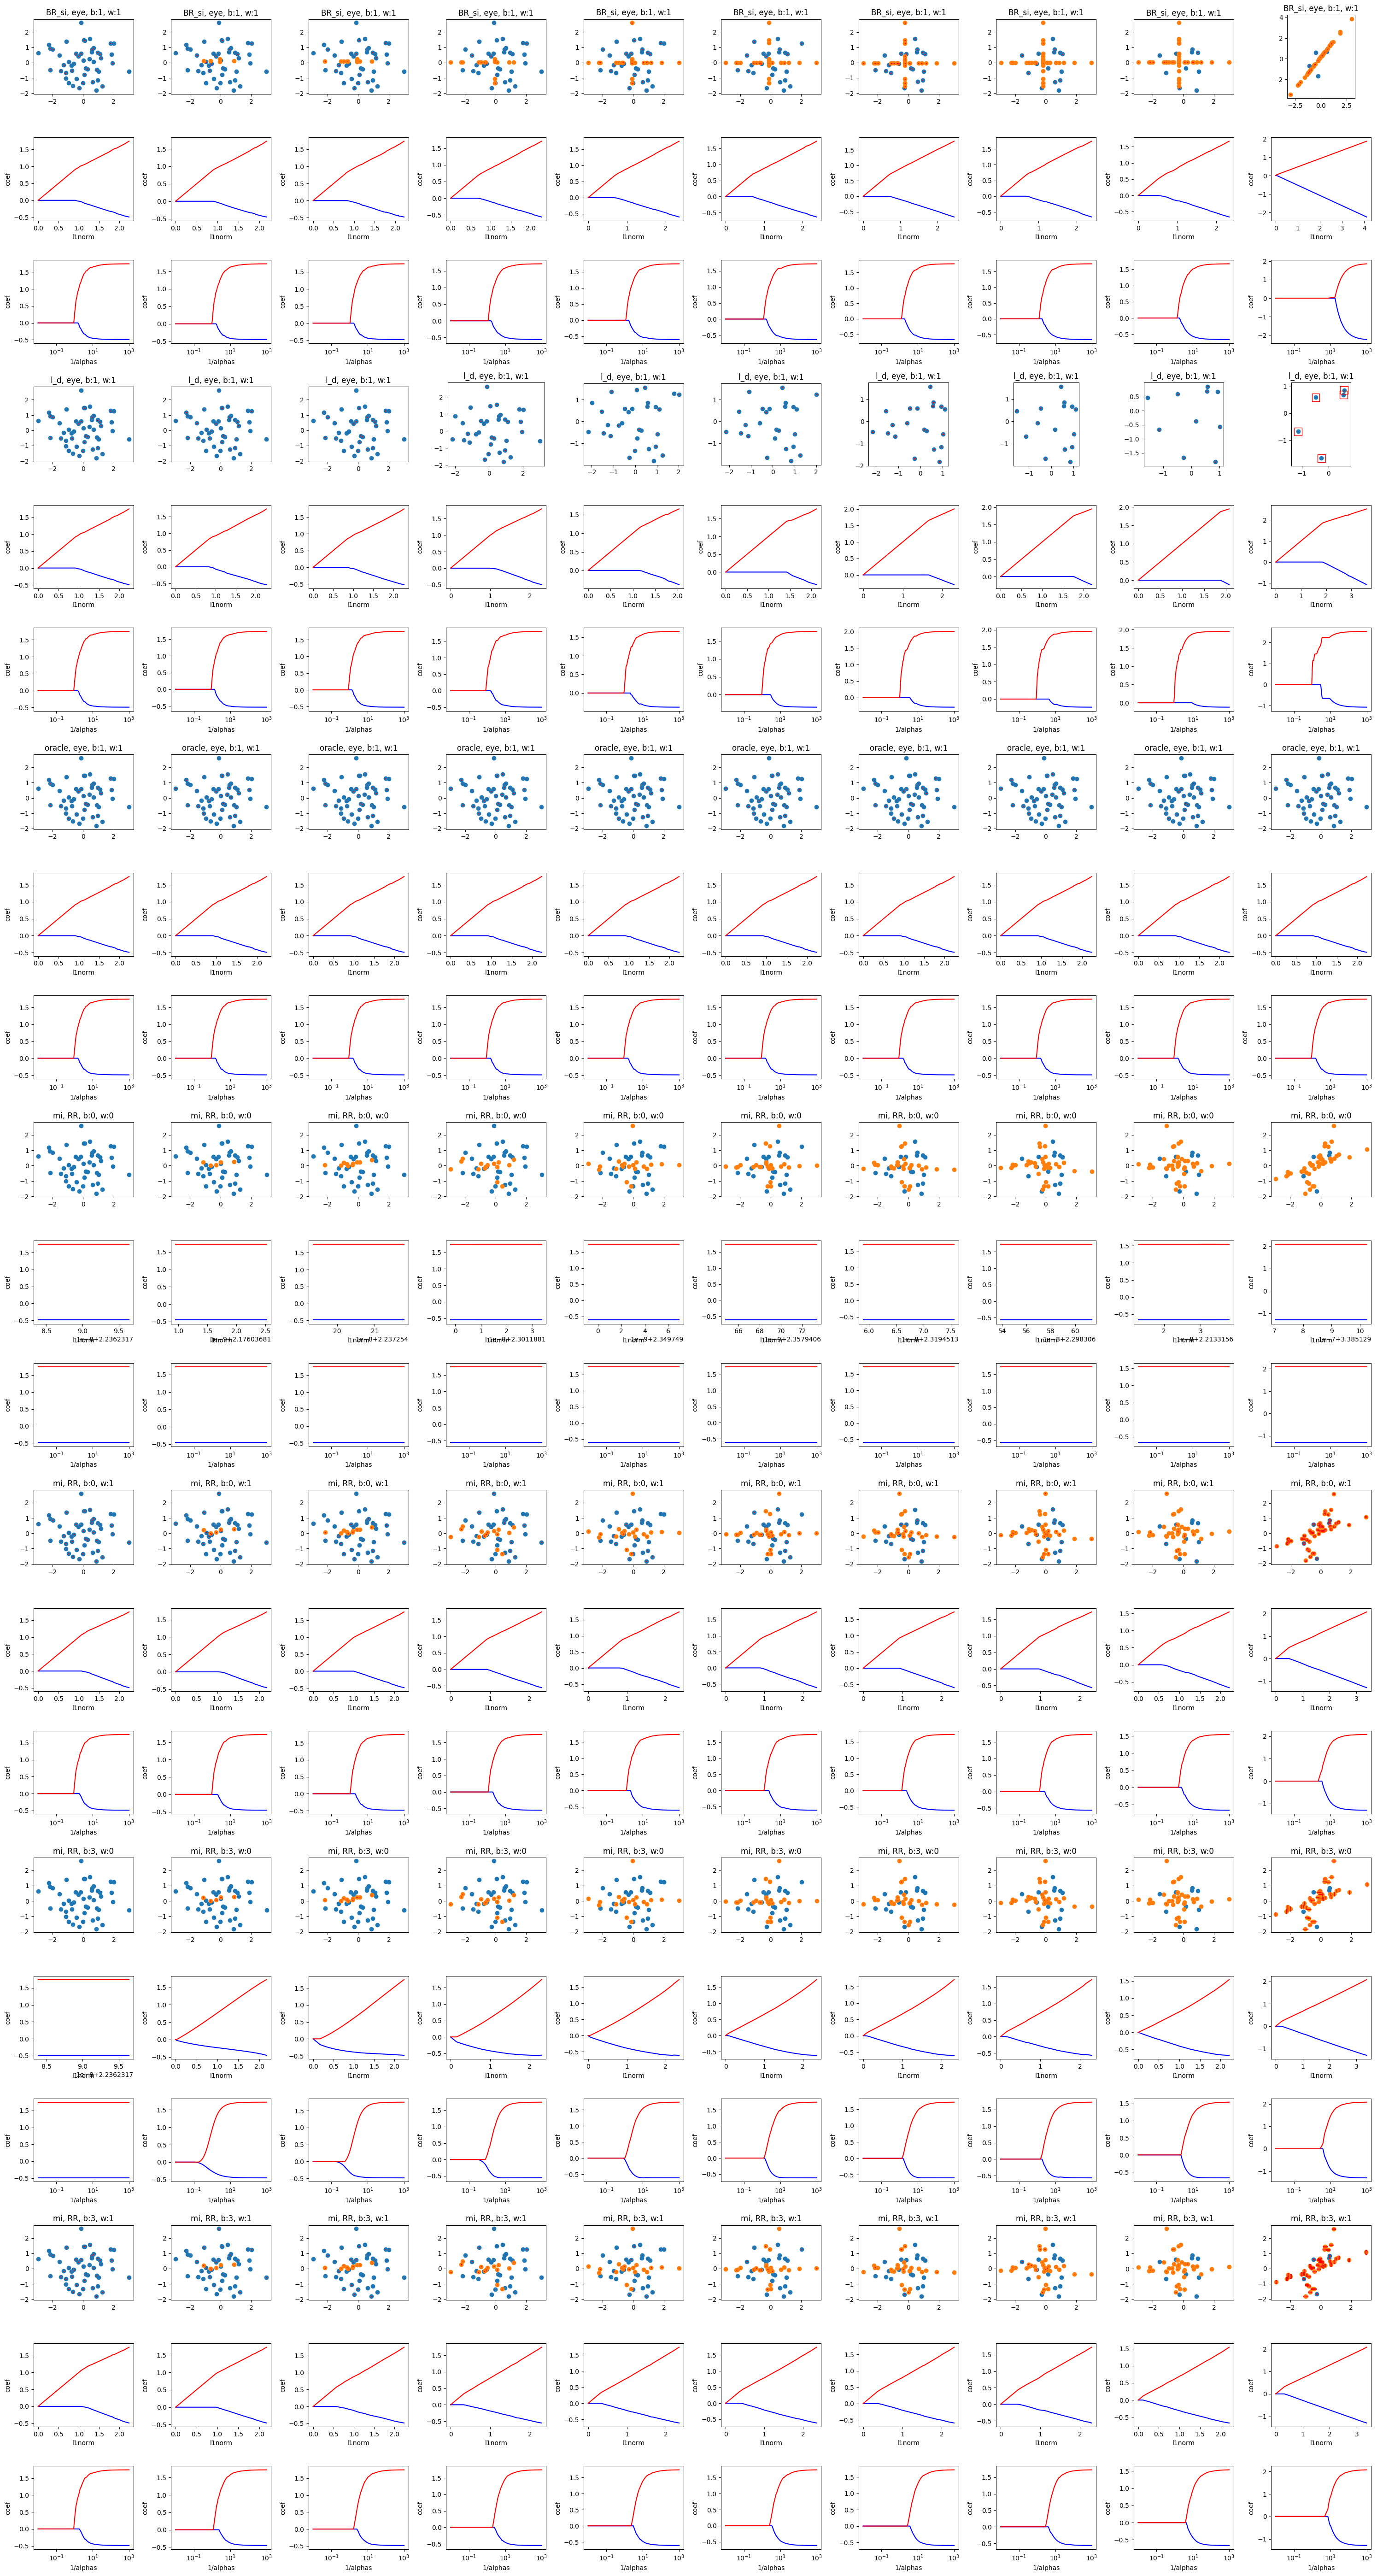

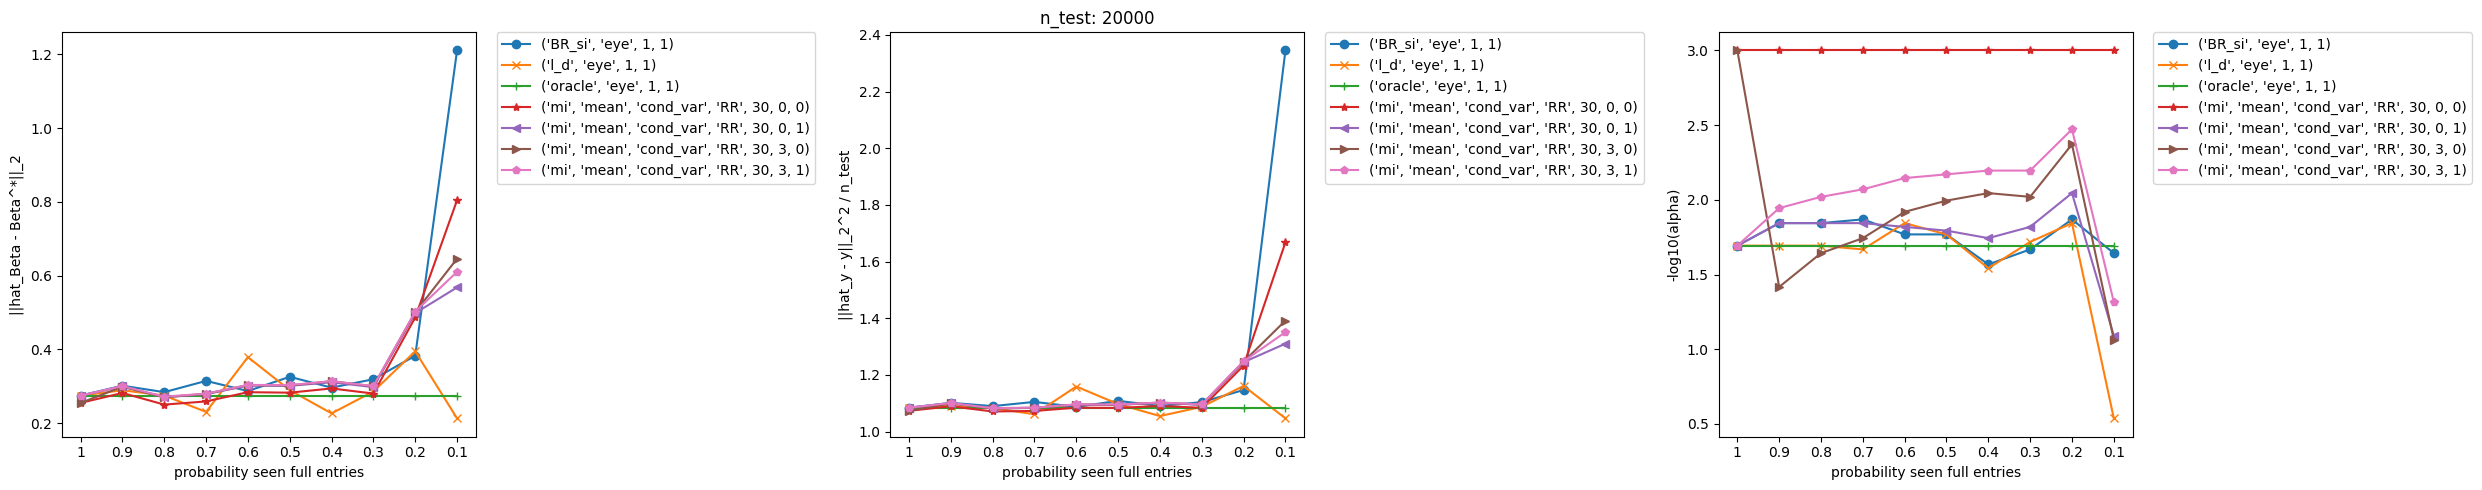

In [ ]:
np.random.seed(456789)

#info_axis = 'train'
#n_train = [400, 800, 1200, 1600, 2000]
#p_seen = make_probabilities([0.8, 0.8, 0.8, 0.8, 0.8])
#main_vec = n_train if info_axis == 'train' else p_seen
#info_x_axis = make_info_axis(main_vec, info_axis)

gen = 'fixed'
info_axis = 'p_seen'  # train or p_seen
#p_seen_both = [1, 0.95, 0.90, 0.85, 0.80, 0.75, 0.70, 0.65, 0.60, 0.55, 0.50, 0.45, 0.40, 0.35, 0.3, 0.25, 0.2, 0.15, 0.1, 0.05, 0.02]
#p_seen_both = [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]
p_seen_both = [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]
#p_seen_both = [1, 0.9, 0.8]
length_vec = len(p_seen_both)
#n_train = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]
n_train = [50] * length_vec
error_vec =  [1] * length_vec
p_seen = make_probabilities(p_seen_both)
if info_axis == 'train':
  main_vec = n_train
elif info_axis == 'p_seen':
  main_vec = p_seen_both
elif info_axis == 'error':
  main_vec = error_vec
#main_vec = n_train if info_axis == 'train' else p_seen_both
info_x_axis = make_info_axis(main_vec, info_axis)


dicc = make_dictionary_data(
    nbr_experiments= len(main_vec), n_train = n_train, n_test=20000,
    data = {'data': 'Normal', 'mean': np.array([0, 0]), 'cov': np.array([[1, -0.1], [-0.1, 1]])},
    beta_gt = np.array([-0.5, 2]),
    p_miss = p_seen,
    err_vector = ['Gaussian_on_y', error_vec],
)
dicc = dicc | {'generation':gen}
for key, value in dicc.items():
  print(key,": " , value[0])

# (imp method, cov strategy, mi_nbr)
#list_imp_cov_methods = [('BR_si', 'sd'), ('l_d', 'sd'), ('mi', 'sd', 1)]

#list_methods_strategy = make_dictionary_method(list_imp_cov_methods)
mi_nbr = 30
list_methods_strategy = [{'imp_method': 'BR_si', 'cov_strategy': 'eye', 'multip_betw': 1, 'multip_with':1},
                        {'imp_method': 'l_d', 'cov_strategy': 'eye', 'multip_betw': 1, 'multip_with':1},
                        {'imp_method': 'oracle', 'cov_strategy': 'eye', 'multip_betw': 1, 'multip_with':1},
                        #{'imp_method': 'mi', 'cov_strategy': 'RR', 'mi_nbr': 1},
                        #{'imp_method': 'mi', 'cov_strategy': 'RR', 'mi_nbr': 3},
                        #{'imp_method': 'mi_pure', 'cov_strategy': 'eye', 'mi_nbr': 2},
                        #{'imp_method': 'mi_pure', 'cov_strategy': 'cond_var', 'cov_strategy_within': 'sd', 'mi_nbr': 5},
                        #{'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'zero', 'mi_nbr': mi_nbr, 'multip_betw': 1, 'multip_with': 1},
                        #{'imp_method': 'mi_mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'eye', 'mi_nbr': 5},
                        {'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'RR', 'mi_nbr': mi_nbr, 'multip_betw': 0, 'multip_with': 0},
                        {'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'RR', 'mi_nbr': mi_nbr, 'multip_betw': 0, 'multip_with': 1},
                        {'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'RR', 'mi_nbr': mi_nbr, 'multip_betw': 3, 'multip_with': 0},
                        {'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'RR', 'mi_nbr': mi_nbr, 'multip_betw': 3, 'multip_with': 1},
                        #{'imp_method': 'mi', 'cov_strategy': 'RR', 'mi_nbr': 5},
                        ]
print(list_methods_strategy)
for el in list_methods_strategy:
  for key, value in el.items():
    print(key,": " , value)

print("----> Starting experiments")
res = run_experiments(dicc, list_methods_strategy)
plot_res(info_x_axis, res, dicc)



## you can see if you manage to take the index i that maximize alpha



In [ ]:
## Setting as before, n=100, 120 sample from mi, error = 1 (mild)
## the best method is the one where S = 0

In [ ]:
X = np.random.randint(2, 5, size=(2, 2, 2))
print(X)

XX = np.concatenate(X)
print(XX)


Y = np.random.randint(2, 5, size=(1, 3, 2))
print(Y)

YY = np.concatenate(Y)
print(YY)


Z = np.random.randint(2, 5, size=(5, 2))
print(Z)

ZZ = np.concatenate(Z)
print(ZZ)

print("other")
s = np.random.randint(2, 4, 5)
print(s)
z = np.tile(s, reps=3)  # np.array([s] * 2)
print(z)


print("other mult")
s = np.random.randint(2, 8, size=(3, 2))
print(s)
z = np.tile(s, reps=(3, 1))  # np.array([s] * 2)
print(z)


[[[4 3]
  [4 3]]

 [[4 3]
  [2 4]]]
[[4 3]
 [4 3]
 [4 3]
 [2 4]]
[[[2 3]
  [2 4]
  [2 4]]]
[[2 3]
 [2 4]
 [2 4]]
[[2 4]
 [3 3]
 [3 2]
 [2 3]
 [3 4]]
[2 4 3 3 3 2 2 3 3 4]
other
[3 3 3 2 2]
[3 3 3 2 2 3 3 3 2 2 3 3 3 2 2]
other mult
[[4 4]
 [7 2]
 [3 7]]
[[4 4]
 [7 2]
 [3 7]
 [4 4]
 [7 2]
 [3 7]
 [4 4]
 [7 2]
 [3 7]]


In [ ]:
'''
## random forest imputer
from sklearn.ensemble import RandomForestRegressor
rf_estimator = RandomForestRegressor(n_estimators=4, max_depth=10, bootstrap=True, max_samples=0.5, n_jobs=2, random_state=0)

X_rf = single_imputation(X_nan, rf_estimator)
print(X_rf.shape)
sd_rf = np.std(X_rf, axis=0)
S_inv_rf = np.diag(1 / sd_rf)
print("std_orig: \n", np.std(X_orig, axis=0))
print("std rf\n ", sd_rf)
fig, ax = plt.subplots(num='advtrain_linf_rf')
linfadvtrain_rf = AdversarialTraining(X_rf, y, S_inv_rf, p=np.inf)
estimator_rf = lambda X, y, a:  linfadvtrain_rf(adv_radius=a)
alphas_adv, coefs_advtrain_linf_rf  = get_path(X_rf, y, estimator_rf, 1e1)
plot_coefs_l1norm(coefs_advtrain_linf_rf, ax)
'''

'\n## random forest imputer\nfrom sklearn.ensemble import RandomForestRegressor\nrf_estimator = RandomForestRegressor(n_estimators=4, max_depth=10, bootstrap=True, max_samples=0.5, n_jobs=2, random_state=0)\n\nX_rf = single_imputation(X_nan, rf_estimator)\nprint(X_rf.shape)\nsd_rf = np.std(X_rf, axis=0)\nS_inv_rf = np.diag(1 / sd_rf)\nprint("std_orig: \n", np.std(X_orig, axis=0))\nprint("std rf\n ", sd_rf)\nfig, ax = plt.subplots(num=\'advtrain_linf_rf\')\nlinfadvtrain_rf = AdversarialTraining(X_rf, y, S_inv_rf, p=np.inf)\nestimator_rf = lambda X, y, a:  linfadvtrain_rf(adv_radius=a)\nalphas_adv, coefs_advtrain_linf_rf  = get_path(X_rf, y, estimator_rf, 1e1)\nplot_coefs_l1norm(coefs_advtrain_linf_rf, ax)\n'

In [ ]:
'''
## iterative imputer Bayesian Ridge

from sklearn.linear_model import BayesianRidge
br_estimator = BayesianRidge()

X_br = single_imputation(X_nan, br_estimator)
sd_br = np.std(X_br, axis=0)
S_inv_br = np.diag(1 / sd_br)
print("std_orig: \n", np.std(X_orig, axis=0))
print("std  br\n ", sd_br)

fig, ax = plt.subplots(num='advtrain_linf_br')
linfadvtrain_br = AdversarialTraining(X_br, y, S_inv_br, p=np.inf)
estimator_br = lambda X, y, a:  linfadvtrain_br(adv_radius=a)
alphas_adv, coefs_advtrain_linf_br  = get_path(X_br, y, estimator_br, 1e4)
plot_coefs_l1norm(coefs_advtrain_linf_br, ax)
'''

'\n## iterative imputer Bayesian Ridge\n\nfrom sklearn.linear_model import BayesianRidge\nbr_estimator = BayesianRidge()\n\nX_br = single_imputation(X_nan, br_estimator)\nsd_br = np.std(X_br, axis=0)\nS_inv_br = np.diag(1 / sd_br)\nprint("std_orig: \n", np.std(X_orig, axis=0))\nprint("std  br\n ", sd_br)\n\nfig, ax = plt.subplots(num=\'advtrain_linf_br\')\nlinfadvtrain_br = AdversarialTraining(X_br, y, S_inv_br, p=np.inf)\nestimator_br = lambda X, y, a:  linfadvtrain_br(adv_radius=a)\nalphas_adv, coefs_advtrain_linf_br  = get_path(X_br, y, estimator_br, 1e4)\nplot_coefs_l1norm(coefs_advtrain_linf_br, ax)\n'

In [ ]:
'''
## mean imputation
from sklearn.impute import SimpleImputer

imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
X_mean = imp_mean.fit_transform(X_nan)
sd_mean = np.std(X_mean, axis=0)
print(sd_mean)
S_inv_mean = np.diag(1 / sd_mean)

fig, ax = plt.subplots(num='advtrain_linf_mean')
linfadvtrain_mean = AdversarialTraining(X_mean, y, S_inv_mean, p=np.inf)
estimator_mean = lambda X, y, a:  linfadvtrain_mean(adv_radius=a)
alphas_adv, coefs_advtrain_linf_mean  = get_path(X_mean, y, estimator_mean, 1e1)
plot_coefs_l1norm(coefs_advtrain_linf_mean, ax)
'''

"\n## mean imputation\nfrom sklearn.impute import SimpleImputer\n\nimp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')\nX_mean = imp_mean.fit_transform(X_nan)\nsd_mean = np.std(X_mean, axis=0)\nprint(sd_mean)\nS_inv_mean = np.diag(1 / sd_mean)\n\nfig, ax = plt.subplots(num='advtrain_linf_mean')\nlinfadvtrain_mean = AdversarialTraining(X_mean, y, S_inv_mean, p=np.inf)\nestimator_mean = lambda X, y, a:  linfadvtrain_mean(adv_radius=a)\nalphas_adv, coefs_advtrain_linf_mean  = get_path(X_mean, y, estimator_mean, 1e1)\nplot_coefs_l1norm(coefs_advtrain_linf_mean, ax)\n"

In [ ]:
'''
# imputation elliptic

mu = np.nanmean(X_nan, axis=0)
print("means ", mu)
delta = np.mean(masks) # parameter missingness
print("delta ", delta)
X_0 = np.nan_to_num(X_nan)
print("nbr obs", X_0.shape[0])
S_ellp =  X_0.T @ X_0 / X_0.shape[0]
S_ellp = (1/delta - 1/(delta**2)) * np.diag(np.diag(S_ellp)) + 1/(delta**2) * S_ellp
print("eig cov ", np.linalg.eigvalsh(S_ellp))
X_ellp = imputation_elliptic(mu, S_ellp, X_nan, masks)
#S_inv_ellp = np.linalg.inv(S_ellp)  # other variance
sd_inv_ellp = np.std(X_ellp, axis=0)
print("sd ellp", sd_inv_ellp)

fig, ax = plt.subplots(num='advtrain_linf_ellp')
linfadvtrain_ellp = AdversarialTraining(X_ellp, y, S_ellp, p=np.inf)
estimator_ellp = lambda X, y, a:  linfadvtrain_ellp(adv_radius=a)
alphas_adv, coefs_advtrain_linf_ellp  = get_path(X_ellp, y, estimator_ellp, 1e1)
plot_coefs_l1norm(coefs_advtrain_linf_ellp, ax)
'''

'\n# imputation elliptic\n\nmu = np.nanmean(X_nan, axis=0)\nprint("means ", mu)\ndelta = np.mean(masks) # parameter missingness\nprint("delta ", delta)\nX_0 = np.nan_to_num(X_nan)\nprint("nbr obs", X_0.shape[0])\nS_ellp =  X_0.T @ X_0 / X_0.shape[0]\nS_ellp = (1/delta - 1/(delta**2)) * np.diag(np.diag(S_ellp)) + 1/(delta**2) * S_ellp\nprint("eig cov ", np.linalg.eigvalsh(S_ellp))\nX_ellp = imputation_elliptic(mu, S_ellp, X_nan, masks)\n#S_inv_ellp = np.linalg.inv(S_ellp)  # other variance\nsd_inv_ellp = np.std(X_ellp, axis=0)\nprint("sd ellp", sd_inv_ellp)\n\nfig, ax = plt.subplots(num=\'advtrain_linf_ellp\')\nlinfadvtrain_ellp = AdversarialTraining(X_ellp, y, S_ellp, p=np.inf)\nestimator_ellp = lambda X, y, a:  linfadvtrain_ellp(adv_radius=a)\nalphas_adv, coefs_advtrain_linf_ellp  = get_path(X_ellp, y, estimator_ellp, 1e1)\nplot_coefs_l1norm(coefs_advtrain_linf_ellp, ax)\n'

TypeError: add_rectangles() takes 4 positional arguments but 5 were given

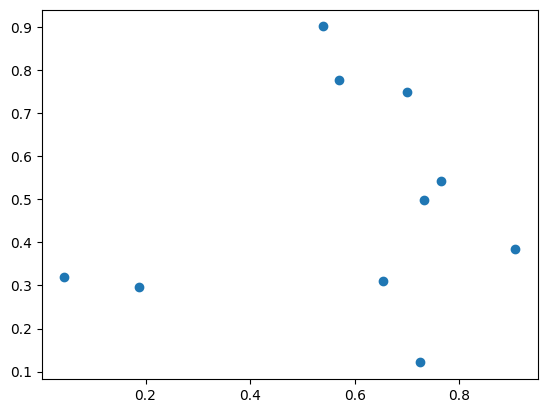

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np


# Example data
x_test_rect = np.random.rand(10)
y_test_rect = np.random.rand(10)

# Plot the points
fig, ax = plt.subplots()
ax.scatter(x_test_rect, y_test_rect)

width = 0.1
height = 0.1

add_rectangles(x_test_rect, y_test_rect, width, height, ax)

# Add the rectangle to the plot


In [ ]:
# Cell for some tests

def test_clear_dataset(n, d):
  print("test clear dataset")
  X = np.random.randint(1, 3, size=(n, d))
  y = np.random.randint(1, 3, size=n)
  masks = np.random.binomial(1, 0.3, size=(n, d))
  print("X \n", X)
  print("y\n", y)
  print("masks \n", masks)
  masks[:, 0] = np.ones(n)
  masks[0, :] = np.ones(d)
  X_res, y_res, masks_res = clear_dataset(X, y, masks)
  print("X_res \n", X_res)
  print("y\n", y_res)
  print("masks \n", masks_res)
  print("test clear dataset ended successfully")

def test_generate_X():
    print("test generate_X started")
    fig, ax = plt.subplots(3, 1, figsize=(10, 8), num='advtrain_linf')
    gen = generate_X('circles', 2)
    data = gen(1000)
    print(data.shape)
    ax[0].scatter(data[:, 0], data[:, 1])
    print("test generate passed syccessfully")

def test_preparation_dataset(n, d):
      print("\ntest preparation dataset started")
      X_train = np.random.rand(n, d)
      print("X_train \n", X_train)
      mask = np.random.binomial(1, 0.5, (n, d))
      print("mask, 0 seen, 1 missing \n ", mask)
      X_masked = X_train * (1 - mask)
      print("X_masked \n", X_masked)
      X_nan_train = X_train.copy()
      X_nan_train[mask == 1] = np.nan
      print("X_nan_train \n", X_nan_train)
      X_br_train = single_imputation(X_nan_train, BayesianRidge())
      print("X_br_train\n ", X_br_train)

      print("what happens if we run single_imputation of full dataset")
      X_br_full = single_imputation(X_train, BayesianRidge())
      print("X_br_full\n ", X_br_full)
      np.testing.assert_allclose(X_train, X_br_full)  # shuold be untouched
      print("test preparation dataset ended successfully")

def test_listwise_delection(n, d):
    print("\n test list_wise delection started")
    X = np.random.rand(n, d)
    print("data\n", X)
    mask = np.random.binomial(1, 0.2, (n, d))
    print("mask \n", mask)
    X_ld = listwise_delection(X, mask)
    print("after calling function, X_ld \n", X_ld)

    print("edge cases, all missing")
    mask_1 = np.ones_like(X)  # all missing
    X1 = listwise_delection(X, mask_1)
    print("X1 \n", X1)  # should be empty
    mask_0 = np.zeros_like(X)  # all seen
    X0 = listwise_delection(X, mask_0)
    print("X0 \n", X0)
    np.testing.assert_allclose(X0, X)  # should be the original dataset

    print("one dimnsional array")
    y = np.random.rand(n)
    print("y before ", y)
    y_ld = listwise_delection(y, mask)
    print("y after ld ", y_ld)
    print("test listwise_delection passed")


test_generate_X()
test_preparation_dataset(3, 4)
test_listwise_delection(3, 4)
test_clear_dataset(6, 3)

xxx = np.random.randint(2, 5, size=(3, 3)) * 1.0
mmm = np.random.binomial(1, 0.5, size=(3, 3))
print(xxx)
print(mmm)
print(mmm == 1)
print(xxx[mmm == 1])
xxx[mmm == 1] = np.nan
print(xxx)
mask_from_xxx = np.isnan(xxx).astype(int)
print("mask from xxx \n", mask_from_xxx)


In [ ]:
# test best predictor

def test_best_predictor(n, d, nb_coeff):
  X_test = np.random.randint(1, 9, size=(n, d))
  beta_gt_test = np.random.randint(1, 7, size=d)
  y_test = X_test @ beta_gt_test
  #print("X_test \n", X_test, "\n beta_gt", beta_gt_test, "\n y_test = X_test @ beta_gt_test ", y_test)
  coeff_test = np.random.randint(1, 5, size=(d, nb_coeff))
  rdm_idx = np.random.randint(1, d+1, size=1)
  print(rdm_idx)
  #print("coeff test partial ", coeff_test[:, -1])
  rng = np.arange(nb_coeff)
  #print(rng != rdm_idx)
  coeff_test[:, rng != rdm_idx] = coeff_test[:, rng != rdm_idx] + 1000  # increase artificially the value of the other coefficient, to induce the minimum index to be rdm_idx
  #print("coeff_test \n", coeff_test)
  best_coeff, best_score = best_predictor(X_test, coeff_test, y_test)
  print("best coeff ", best_coeff)
  print("best score ", best_score)
  np.testing.assert_allclose(best_coeff, coeff_test[:,rdm_idx].squeeze())
  print("test best predictor passed")

test_best_predictor(100, 5, 20)




In [ ]:
# test train_and_plot

X_diab, y_diab = datasets.load_diabetes(return_X_y=True)
n, d = X_diab.shape
print("n:  ", n, ", d: ", d)
# Standardize data
X_diab -= X_diab.mean(axis=0)
X_diab /= X_diab.std(axis=0)

## original lasso
fig_l, ax_l = plt.subplots(num='lasso')
alphas_lasso, coefs_lasso, _ = get_lasso_path(X_diab, y_diab)
plot_coefs_l1norm(coefs_lasso, ax_l)

## Antonio's algo, 1 matrix
S_diab_eye = np.eye(X_diab.shape[1])
fig, ax_1 = plt.subplots(1, 1, num='advtrain_linf_diab')
fig, ax_2 = plt.subplots(1, 1, num='advtrain_linf_diab_2')
train_and_plot(X_diab, y_diab, S_diab_eye, [ax_1, ax_2])

## Antonio's algo, multiple diagonal matrix
#S_diab = np.eye(X_diab.shape[1])
#S_diab = np.random.randint(1, 3, size=(n, d))
#print(S_diab)
#fig, ax_5 = plt.subplots(1, 1, num='advtrain_linf_diab_5')
#fig, ax_6 = plt.subplots(1, 1, num='advtrain_linf_diab_6')
#train_and_plot(X_diab, y_diab, S_diab, [ax_5, ax_6])


## Antonio's algo, multiple matrices (same matrix stacked multiple time)
S_diab_stacked = np.array([S_diab_eye] * X_diab.shape[0])
S_diab_stacked = np.concatenate(S_diab_stacked)
fig, ax_3 = plt.subplots(1, 1, num='advtrain_linf_diab_3')
fig, ax_4 = plt.subplots(1, 1, num='advtrain_linf_diab_4')
train_and_plot(X_diab, y_diab, S_diab_stacked, [ax_3, ax_4])




In [ ]:
# test imputations

np.random.seed(45)


def test_imputations(n, d):
  X = np.random.randint(2, 5, size=(n, d)) * 1.0
  y = X @ np.random.randint(1, 3, size=d)
  m = np.random.binomial(1, 0.4, size=(n, d))  # 1 missing, 0 seen
  print("m original\n", m)
  X, y, m = clear_dataset(X, y, m)
  print(m)
  X_nan = X.copy()
  X_nan[m == 1] = np.nan

  #mask_from_xxx = np.isnan(xxx).astype(int)
  print("X\n ", X)
  print("masks \n", m)
  print("X_nan\n ", X_nan)
  methods = ['BR_si', 'mi', 'l_d']
  nbr_mi = [1, 3]
  #for method in methods:
  #  dict_info = {'imp_method': method, 'mi_nbr':nbr_mi}
  #dict_info = {'imp_method':methods, 'mi_nbr':nbr_mi}
  for method in methods:
    print("---------- method: ", method)
    if method == 'mi':
      for x in nbr_mi:
        print("-------------------- nbr mi: ", x)
        dict_info = {'imp_method':method, 'mi_nbr':x}
        #print("XNANNANAN ", X_nan)
        X_res, y_res, mask_res = imputations(dict_info, X_nan, y)
        print(X_res, y_res, "\n", mask_res)
    else:
      dict_info = {'imp_method': method}
      X_res, y_res, mask_res = imputations(dict_info, X_nan, y)
      print(X_res, y_res, "\n", mask_res)
    print("test imputations ended successfully")

test_imputations(6, 3)


In [ ]:
x = []
y = np.array([1, 2])
x.append(y)
x.append(y)
x.append(y)
xx = np.stack(x)
print(x)
print(xx)
print(type(xx))


import matplotlib.pyplot as plt

sizes = [100, 1000, 10000, 100000]
values = [0.8, 0.85, 0.9, 0.92]
positions = range(len(sizes))

plt.plot(positions, values, marker='o', label='Model Accuracy')  # Add label here
plt.xticks(positions, sizes)

plt.xlabel("Dataset Size (equispaced)")
plt.ylabel("Accuracy")
plt.title("Performance vs Dataset Size (equispaced x-axis)")
#plt.legend()  # Show legend
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.show()



In [ ]:

dictio = {'a':1, 'b':2, 'c':3}
vv = dictio.values()
#print(vv)
#print(vv[1])

x1 = np.array([1, 2, 3])
x2 = np.array([3, 2 ,1])
v = np.maximum(x1, x2)
print(v)


In [ ]:
m, n, d = 2, 3, 2
x_int = np.random.randint(1, 9, (m, n, d))
print(x_int)
s = np.std(x_int, axis=0)
print(s)

# manual
print("manual computation")
x = np.zeros((m, d))
for i in range(n):
  print("i -----> ", i)
  x = x_int[:, i, :]
  print("x\n", x)
  ss = np.std(x, axis=0)
  print(ss)


print("little exp on squeeze")
sss = np.random.rand(1, 3, 3)
print(sss)
print(sss.squeeze())
print(sss.squeeze())



In [15]:
int(34.99)

xxxx = np.random.randint(2, 4, (5, 2))
print(xxxx)
xxxx[0:2, :] = 1
print(xxxx)

print("yyyy\n")
yy = []
yy.append([1, 2, 3])
yy.append([4, 5, 6])
print(yy)
print(np.stack( yy ).T)


[[3 3]
 [2 2]
 [2 3]
 [2 2]
 [3 3]]
[[1 1]
 [1 1]
 [2 3]
 [2 2]
 [3 3]]
yyyy

[[1, 2, 3], [4, 5, 6]]
[[1 4]
 [2 5]
 [3 6]]
